In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd

In [2]:
def incorporate_bc_info(unmappedR1, mappedR2, counts, outputFile):
    unmapped_df = dd.read_csv(unmappedR1, dtype='str', header=None, sep=" ")
    unmapped_df.columns = ['Transcript ID', 'Cell Barcode', 'UMI']
    mapped_df = dd.read_csv(mappedR2, dtype='str', header=None, sep=" ")
    mapped_df.columns = ["Transcript ID", "Barcode"]
    merged_df = dd.merge(mapped_df, unmapped_df, how='inner', on = 'Transcript ID')
    merged_df_first = merged_df.drop_duplicates(subset='Cell Barcode', keep='first')
    merged_df_pandas = merged_df_first.compute()
    sc_data = pd.read_csv(counts)
    sc_data = sc_data.T
    sc_data.reset_index(inplace=True)
    sc_data.columns = sc_data.iloc[0].tolist()
    sc_data.drop(0, axis=0, inplace=True)
    cell_barcode_reads = sc_data['Unnamed: 0']
    cell_barcode_reads_trimmed = [cb.replace('-1', '') for cb in cell_barcode_reads]
    sc_data['Cell Barcode'] = cell_barcode_reads_trimmed
    sc_data.drop('Unnamed: 0', axis=1, inplace=True)
    sc_lineage_data = pd.merge(merged_df_pandas, sc_data, how = "right", on = "Cell Barcode")
    sc_lineage_data.to_csv(outputFile)
    return sc_lineage_data

In [3]:
sc_lineage_data_UT = incorporate_bc_info(unmappedR1 = 'SKMEL5_undiversified_treated_mapped_R1_threecol.csv',
                                      mappedR2 = 'output_SKMEL5_undiversified_treated_mapped_sequences_match.csv',
                                      counts = 'SKMEL5_treated_undiversified_scRNAseq.csv',
                                      outputFile = 'SKMEL5-undiversified-treated_scRNAseq-Lineage-Transcript-Cell-UMI.csv')
#sc_lineage_data = pd.read_csv('SKMEL5-undiversified-untreated_scRNAseq-Lineage-Transcript-Cell-UMI.csv')'output_SKMEL5_undiversified_untreated_mapped_sequences_match.csv'

In [5]:
sc_lineage_data_UT.shape

(3524, 25374)

In [6]:
sc_lineage_data_dropna = sc_lineage_data_UT.dropna(subset=['Barcode'])
sc_lineage_data_dropna.shape

(3504, 25374)

In [7]:
# Remove rows where the lineage barcode is not between 17 and 23 nt long (supposed to be 16nt)
sc_lineage_data_dropna['Barcode'] = sc_lineage_data_dropna['Barcode'].astype('str')
mask = (sc_lineage_data_dropna['Barcode'].str.len() >= 17) & (sc_lineage_data_dropna['Barcode'].str.len() <= 23)
sc_lineage_data_dropna_correctbc = sc_lineage_data_dropna.loc[mask]
sc_lineage_data_dropna_correctbc.shape

/Users/Corey/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(3497, 25374)

In [8]:
bc_values = sc_lineage_data_dropna_correctbc.ix[:,1:5]
sc_values = sc_lineage_data_dropna_correctbc.ix[:,5:]
bc_values.shape

/Users/Corey/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


(3497, 4)

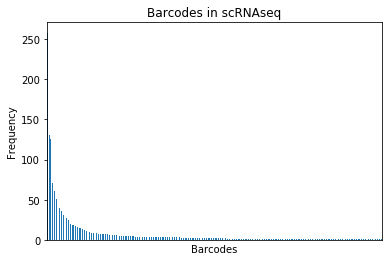

In [11]:
%matplotlib inline
bc_values['Barcode'].value_counts().plot(kind='bar')
axes = plt.gca()
axes.axes.get_xaxis().set_ticks([])
plt.xlabel("Barcodes")
plt.ylabel("Frequency")
plt.title("Barcodes in scRNAseq")
plt.savefig('barcodes_ut_scRNAseq.pdf')

In [10]:
bc_values['Barcode'].value_counts().head()

CTGAGAGTGAGTCTGTCAGT    258
CTGAGTCAGAGTGACACACT    176
CTGACAGACACTCTCAGTCT    139
CTGAGTGTGAGAGTGTGTGT    130
CTGAGTCACTCACTGAGTGT    125
Name: Barcode, dtype: int64

In [12]:
scRNAseq_barcode_list = bc_values['Barcode'].tolist()
scRNAseq_barcode_list
bc_values['Barcode'].nunique()

480

In [13]:
import Levenshtein
import numpy as np
from sklearn.cluster import DBSCAN

def lev_metric(x,y):
    i,j = int(x[0]), int(y[0])
    return Levenshtein.distance(scRNAseq_barcode_list[i], scRNAseq_barcode_list[j])

X = np.arange(len(scRNAseq_barcode_list)).reshape(-1,1)
db = DBSCAN(metric = lev_metric, eps=2, min_samples=2)
pred = db.fit_predict(X)

df = pd.DataFrame({'barcode': scRNAseq_barcode_list,
                   'cluster_id': pred})
df.sort_values(by=['cluster_id'], ascending = True, inplace = True)
df

barcode  cluster_id
614   CTGAGAGAGACTGTCTCTGA          -1
2017  CTGACACTCAGACTGACACA          -1
285   ATGAGTCAGTCAGAGAGATT          -1
3329    CACACAGACAGAGTCTCT          -1
2136  CTGACAGAGACTGACAGACA          -1
272   CTGAGAGTGACACTCAGTCA          -1
2252  CTGACTGAGACTGTGTCAGT          -1
2305  CTGACAGAGTCTGACTCACA          -1
2366  CTGACACAGTGAGTCAGACA          -1
2452  CTGACAGTGACAGACTGTCA          -1
2469  CTGAGACAGTGAGACTCTGT          -1
2541  CTGACTCTCACTGAGACTGT          -1
2566  CTGACTGTGTCAGTGTCTCA          -1
3297  CTGACACTCTCACTGTGTGT          -1
2590  CTGAGTCTGACTCTCAGTCT          -1
2621  CTGAGACACTCTCACTGTGA          -1
3281  CTGACTCAGAGTCACAGACT          -1
189   CTGAGTCTCAGAGAGTCTCT          -1
3076  CTGAGAGTGAGTCTCAGAGT          -1
3043  CTGAGTCAGAGACACACTGA          -1
3042  CTGAGAGACTCAGTGTGTCT          -1
3029  CTGACTCTGTCTCTGACTCA          -1
3021  CTGAGAGTGAGTGACAGTGT          -1
2980  CTGAGTGACAGTCTCACTCT          -1
1981  CTGACACTGTGAGTCACTCA          -1
2937  CTGAGAGTGAGAGACTGTGA          -1
3248  CTGAGTGTCTCACTCTGAGA          -1
2798  CTGACAGAGTGAGACACTGT          -1
158   CTGACAGTGACTCACACAGT          -1
2786  CTGACTGAGACACAGAGACT          -1
...                    ...         ...
1881  CTGAGAGTGAGTGTGAGTCA         154
3141  CTGAGAGTGAGTGTGAGTCA         154
2969  CTGAGAGAGTCTCTCAGACA         155
2547  CTGAGAGAGTCTCTCAGACA         155
2005  CTGAGAGAGTCTCTCAGACA         155
3474   CTGAGTGAGAGAGTGACGA         156
3397   CTGAGTGAGAGAGTGACGA         156
2064   CTGAGTGAGAGAGTGACGA         156
2143   CTGAGTGAGAGAGTGACGA         156
2737  CTGAGACAGTCAGTGTCAGA         157
2178  CTGAGACAGTCAGTGTCAGT         157
2718  CTGAGACAGTCAGTGTCAGA         157
3362  CTGAGAGTCTGTGTGTCTGA         158
2215  CTGAGAGTGTGTGTGTCTCA         158
2330  CTGAGAGAGACAGTGAGACA         159
3250  CTGAGAGAGACAGTGAGACA         159
3473  CTGAGTCACTGACTCTGACT         160
2373  CTGAGTCACTGACTCTGACT         160
2504  CTGACTCACAGTGTCAGACA         161
2891  CTGACTCACAGTGTCAGACA         161
2540  CTGAGACACACTGTGAGACT         162
3350  CTGAGACACACTGTGAGACT         162
3426  CTGAGTCTCTGACTGTCACA         163
2725  CTGAGTCTCTGACTGTCACA         163
3111  CTGAGTGAGAGTGTGAGAGT         164
3090  CTGAGTGAGAGTGTGAGAGT         164
3457  CTGAGAGTCTCAGTGTCTGT         165
3347  CTGAGAGTCTCAGTGTCTGT         165
3446  CTGAGAGTCACTCTGAGAGA         166
3421  CTGAGAGTCACTCTGAGAGA         166

[3497 rows x 2 columns]

In [14]:
## Data Cleaning - using suggested thresholds from ScanPy ##
# Filter out cells with less than 200 genes
nonzeroes_in_cols = sc_lineage_data_dropna_correctbc.astype(bool).sum(axis=1)
# nonzeroes_in_cols
sum(i > 200 for i in nonzeroes_in_cols)
cell_norm_ind = nonzeroes_in_cols.index[nonzeroes_in_cols > 200].tolist()
sc_cellnorm = sc_lineage_data_dropna_correctbc.ix[cell_norm_ind]
sc_cellnorm = sc_cellnorm.ix[:,1:]
sc_cellnorm.shape

/Users/Corey/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


(3497, 25373)

In [15]:
# Filter out genes with less than 3 cells
nonzeroes_in_rows = sc_cellnorm.astype(bool).sum(axis=0)
# nonzeroes_in_rows.head(100)
sum(i > 3 for i in nonzeroes_in_rows)
gene_norm_ind = nonzeroes_in_rows.index[nonzeroes_in_rows > 3].tolist()
# gene_norm_ind
sc_cellgenenorm = sc_cellnorm[gene_norm_ind]
sc_cellgenenorm.shape

(3497, 15174)

In [16]:
sc_cellgenenorm.head()

Barcode      Cell Barcode         UMI WASH7P LOC100288069  \
0  CTGAGTGAGTGTCTGTGTGT  ACACTGACATGGTCTA  CCTCTACGGG      0            0   
1  CTGACTGTGTGTCAGTGTGA  CAGCCGAGTCAGGACA  ATTTTACGCT      0            0   
2  CTGAGAGTGTGTGTCAGACA  GAACCTACATAAAGGT  GCTTGATCTT      0            0   
3  CTGACAGTCACACTGACTCA  CTCGTACCAATGACCT  ACATATTTAT      0            0   
4  CTGACAGTGTGTCAGTCTCT  TACCTATCACTTGGAT  CCAATGGATT      0            0   

  FAM87B LINC00115 LINC01128 FAM41C SAMD11 ...  MTCP1 BRCC3 VBP1 RAB39B CLIC2  \
0      0         0         1      0      0 ...      0     1    4      0     0   
1      0         0         0      0      0 ...      0     0   10      0     0   
2      0         0         1      0      0 ...      0     0    2      0     0   
3      0         0         2      0      0 ...      0     0    1      0     0   
4      0         0         0      0      0 ...      0     0    2      0     0   

  TMLHE SPRY3 VAMP7 PCDH11Y CD24  
0     1     0     0       0    0  
1     0     0     0       0    0  
2     1     0     2       0    0  
3     0     0     0       0    0  
4     1     0     1       0    0  

[5 rows x 15174 columns]

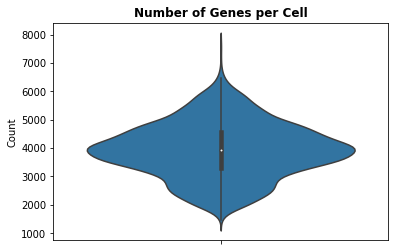

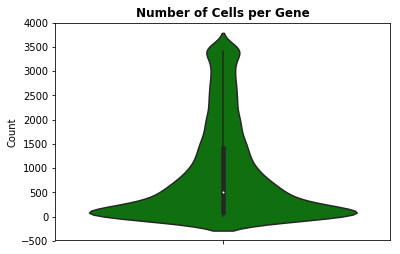

In [17]:
import seaborn as sns
%matplotlib inline

num_genes_percell = sc_cellgenenorm.astype(bool).sum(axis=1)
num_cells_pergene = sc_cellgenenorm.astype(bool).sum(axis=0)
num_cells_pergene_rmbarcodes = num_cells_pergene[4:]

plt.figure()
sns.violinplot(num_genes_percell, orient = "v")
# plt.xlabel("")
plt.ylabel("Count")
plt.title("Number of Genes per Cell", weight = "bold")
plt.savefig("QC_metrics_ngenes_UT.pdf")

plt.figure()
sns.violinplot(num_cells_pergene_rmbarcodes, orient= "v", color="green")
plt.ylabel("Count")
plt.title("Number of Cells per Gene", weight = "bold")
# fig,axes = plt.subplots()
# axes.violinplot(dataset = num_genes_percell)
plt.savefig("QC_metrics_ncells_UT.pdf")

In [22]:
## Data normalization - see powerpoint for detailed explanation ##
import numpy as np
from numpy import inf

totGE_percell = sc_cellgenenorm.ix[:,4:].sum(axis = 1)
totGE_percell_norm = sc_cellgenenorm.ix[:,4:].div(totGE_percell, axis=0)
totGE_percell_norm_scaled = totGE_percell_norm * 100000 #len(totGE_percell_norm.index)
totGE_percell_norm_scaled_log = np.log(totGE_percell_norm_scaled.astype(float))
totGE_percell_norm_scaled_log_noInf = totGE_percell_norm_scaled_log.replace([np.inf, -np.inf], 0)
totGE_percell_norm_scaled_log_noInf.shape

/Users/Corey/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


(3497, 15170)

In [23]:
totGE_percell_norm_scaled_log_noInf.head()

LOC100288069  FAM87B  LINC00115  LINC01128  FAM41C  SAMD11     NOC2L  \
0           0.0     0.0        0.0   0.810063     0.0     0.0  0.810063   
1           0.0     0.0        0.0   0.000000     0.0     0.0  1.442484   
2           0.0     0.0        0.0   0.916391     0.0     0.0  0.000000   
3           0.0     0.0        0.0   2.182316     0.0     0.0  1.489169   
4           0.0     0.0        0.0   0.000000     0.0     0.0  0.000000   

     KLHL17  PLEKHN1  PERM1  ...   MTCP1     BRCC3      VBP1  RAB39B  CLIC2  \
0  0.810063      0.0    0.0  ...     0.0  0.810063  2.196357     0.0    0.0   
1  0.000000      0.0    0.0  ...     0.0  0.000000  3.051922     0.0    0.0   
2  0.000000      0.0    0.0  ...     0.0  0.000000  1.609538     0.0    0.0   
3  0.000000      0.0    0.0  ...     0.0  0.000000  1.489169     0.0    0.0   
4  0.000000      0.0    0.0  ...     0.0  0.000000  1.822446     0.0    0.0   

      TMLHE  SPRY3     VAMP7  PCDH11Y  CD24  
0  0.810063    0.0  0.000000      0.0   0.0  
1  0.000000    0.0  0.000000      0.0   0.0  
2  0.916391    0.0  1.609538      0.0   0.0  
3  0.000000    0.0  0.000000      0.0   0.0  
4  1.129298    0.0  1.129298      0.0   0.0  

[5 rows x 15170 columns]

In [24]:
# Put the dataframe back together with normalized data
sc_data_UT_norm = pd.concat([sc_cellgenenorm.ix[:,:4], totGE_percell_norm_scaled_log_noInf], axis = 1)
sc_data_UT_norm.shape

(3497, 15174)

In [25]:
sc_data_UT_norm.head()

Barcode      Cell Barcode         UMI WASH7P  LOC100288069  \
0  CTGAGTGAGTGTCTGTGTGT  ACACTGACATGGTCTA  CCTCTACGGG      0           0.0   
1  CTGACTGTGTGTCAGTGTGA  CAGCCGAGTCAGGACA  ATTTTACGCT      0           0.0   
2  CTGAGAGTGTGTGTCAGACA  GAACCTACATAAAGGT  GCTTGATCTT      0           0.0   
3  CTGACAGTCACACTGACTCA  CTCGTACCAATGACCT  ACATATTTAT      0           0.0   
4  CTGACAGTGTGTCAGTCTCT  TACCTATCACTTGGAT  CCAATGGATT      0           0.0   

   FAM87B  LINC00115  LINC01128  FAM41C  SAMD11  ...   MTCP1     BRCC3  \
0     0.0        0.0   0.810063     0.0     0.0  ...     0.0  0.810063   
1     0.0        0.0   0.000000     0.0     0.0  ...     0.0  0.000000   
2     0.0        0.0   0.916391     0.0     0.0  ...     0.0  0.000000   
3     0.0        0.0   2.182316     0.0     0.0  ...     0.0  0.000000   
4     0.0        0.0   0.000000     0.0     0.0  ...     0.0  0.000000   

       VBP1  RAB39B  CLIC2     TMLHE  SPRY3     VAMP7  PCDH11Y  CD24  
0  2.196357     0.0    0.0  0.810063    0.0  0.000000      0.0   0.0  
1  3.051922     0.0    0.0  0.000000    0.0  0.000000      0.0   0.0  
2  1.609538     0.0    0.0  0.916391    0.0  1.609538      0.0   0.0  
3  1.489169     0.0    0.0  0.000000    0.0  0.000000      0.0   0.0  
4  1.822446     0.0    0.0  1.129298    0.0  1.129298      0.0   0.0  

[5 rows x 15174 columns]

ValueError: low >= high

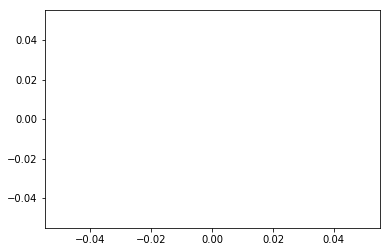

In [26]:
geneMeans_noNorm = sc_cellgenenorm.mean(axis = 1)
geneVars_noNorm = sc_cellgenenorm.var(axis = 1)

sns.regplot(x=geneMeans_noNorm,y=geneVars_noNorm, color = "red")
plt.xlabel("Average Gene Expression")
plt.ylabel("Variance")
plt.title("No Normalization", weight = "bold")
plt.savefig("AvgGE_Var_noNorm_UT.pdf")

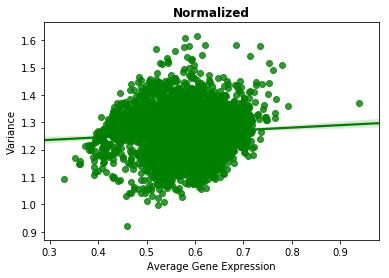

In [27]:
geneMeans_norm = totGE_percell_norm_scaled_log_noInf.mean(axis = 1)
geneVars_norm = totGE_percell_norm_scaled_log_noInf.var(axis = 1)

sns.regplot(x=geneMeans_norm,y=geneVars_norm, color = "green")
plt.xlabel("Average Gene Expression")
plt.ylabel("Variance")
plt.title("Normalized", weight = "bold")
plt.savefig("AvgGE_Var_Norm_UT.pdf")

In [28]:
# Indexing barcodes so that you can color them on plot
norm_bc_names = sc_data_UT_norm['Barcode']
norm_bc_names_indexed = norm_bc_names.astype('category')
norm_bc_names_numindexed = norm_bc_names_indexed.cat.codes
norm_bc_names_indexed.value_counts().head()

CTGAGAGTGAGTCTGTCAGT    258
CTGAGTCAGAGTGACACACT    176
CTGACAGACACTCTCAGTCT    139
CTGAGTGTGAGAGTGTGTGT    130
CTGAGTCACTCACTGAGTGT    125
Name: Barcode, dtype: int64

In [29]:
from sklearn.decomposition import PCA
# Principal Component Analysis (PCA) of whole normalized dataset
norm_pca = PCA(n_components=2)
norm_sc_values_r = norm_pca.fit(sc_data_UT_norm.iloc[:,4:])
norm_sc_values_r_transform = norm_pca.fit(sc_data_UT_norm.iloc[:,4:]).transform(sc_data_UT_norm.iloc[:,4:])

In [30]:
# Getting number of colors the length of unique barcodes
from random import randint
colors = []
lw = 2

for i in range(len(norm_bc_names.unique())):
    colors.append('#%06X' % randint(0, 0xFFFFFF))
    
colors

['#929A69',
 '#B0E119',
 '#6170C9',
 '#26B1A7',
 '#7841B9',
 '#751DFF',
 '#554EA2',
 '#534D87',
 '#654CFB',
 '#D331C0',
 '#8857B0',
 '#FA45BB',
 '#9D3C1E',
 '#FE3C3D',
 '#1484D5',
 '#B14447',
 '#B17C85',
 '#E8A5A5',
 '#F3558A',
 '#5AE50C',
 '#622F76',
 '#1419B4',
 '#B62F9E',
 '#BFA29A',
 '#62FC35',
 '#2B510B',
 '#71F6FA',
 '#82DBEA',
 '#3F1276',
 '#D41688',
 '#3A2A8B',
 '#C4AB9B',
 '#528BB3',
 '#53D2DF',
 '#0E159E',
 '#9848FF',
 '#B6C585',
 '#FBD1AA',
 '#78999B',
 '#EB359A',
 '#0B730A',
 '#3700E2',
 '#1F478D',
 '#F318C9',
 '#B4F9BF',
 '#0E8C66',
 '#C76515',
 '#19159C',
 '#82D562',
 '#328887',
 '#D9AFDA',
 '#E2C9C5',
 '#81ED36',
 '#EBD556',
 '#EDC9F3',
 '#A66C38',
 '#D3A438',
 '#8857F4',
 '#BDF5C5',
 '#8FD5E7',
 '#90E5CA',
 '#BF1035',
 '#68DBD1',
 '#60F04A',
 '#993EF8',
 '#955D4B',
 '#A34E9A',
 '#495DAA',
 '#559788',
 '#6E0E5B',
 '#2D5010',
 '#359549',
 '#B54377',
 '#9BAB77',
 '#1E397D',
 '#695AE9',
 '#33526E',
 '#47E323',
 '#853275',
 '#113CAC',
 '#75EE8E',
 '#63E046',
 '#F451E5',
 '#2

explained variance ratio (first two components): [ 0.03297796  0.01462184]


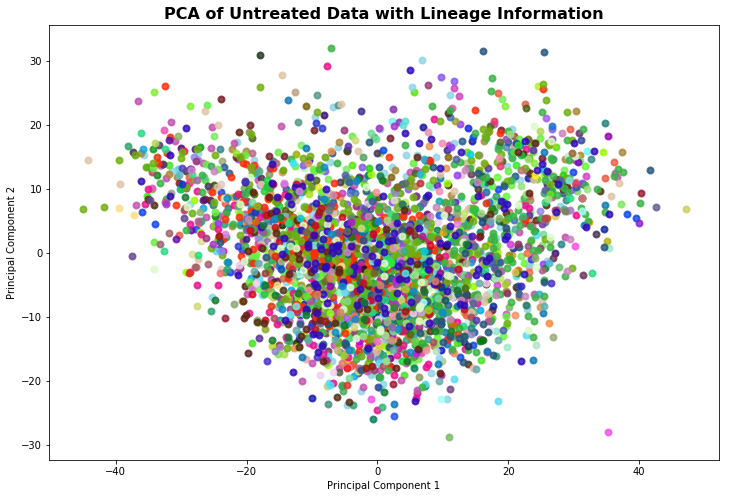

In [31]:
# Plot normalized data PCA with lineage information
% matplotlib inline

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(norm_pca.explained_variance_ratio_))

dims = (12,8)

fig,ax = plt.subplots(figsize=dims)

for color, i, bc_name in zip(colors, range(len(norm_bc_names.unique())), norm_bc_names.unique()):
    plt.scatter(norm_sc_values_r_transform[norm_bc_names_numindexed==i,0], 
                norm_sc_values_r_transform[norm_bc_names_numindexed==i,1], 
                color=color, alpha=0.8, lw=2, 
                label = bc_name)
# plt.legend(loc='best', shadow=False, scatterpoints=1, title="Barcode (Top 10)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title('PCA of Untreated Data with Lineage Information', fontsize = 16, weight = "bold")
plt.savefig('PCA_untreated_lineage_norm_UT.pdf')

In [32]:
from sklearn.decomposition import PCA
# Principal Component Analysis (PCA) of whole normalized dataset
norm_pca_3d = PCA(n_components=3)
norm_sc_values_r_3d = norm_pca.fit(sc_data_UT_norm.iloc[:,4:])
norm_sc_values_r_transform_3d = norm_pca_3d.fit(sc_data_UT_norm.iloc[:,4:]).transform(sc_data_UT_norm.iloc[:,4:])

In [33]:
norm_sc_values_r_transform_3d

array([[ 35.19981828,  18.26052231,   5.16814707],
       [ 25.43812108,  15.76022466,  10.01984307],
       [ 25.27121695,   2.96633685,  19.13740447],
       ..., 
       [  6.89414209,  12.12076014,  -5.88849583],
       [-10.85051198,  -6.72500306,   1.08406762],
       [  8.58877553, -14.66174787,  -5.27916934]])

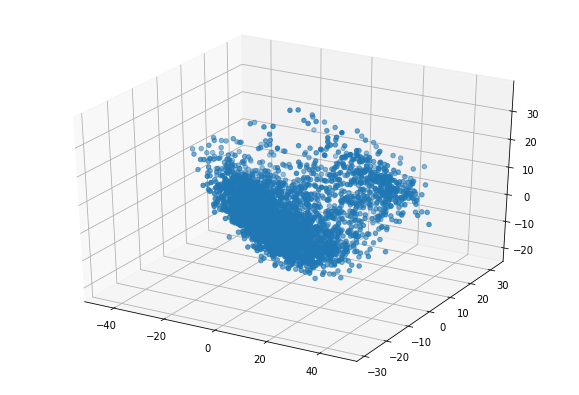

In [34]:
from mpl_toolkits.mplot3d import Axes3D
def plot_3d(data):#, colors):    
  w, y, z = data.T
  fig = plt.figure(figsize=(10, 5.5/8*10))  
  ax1 = fig.add_subplot(111, projection='3d')
  ax1.scatter(w, y, z)#, color=colors)
plot_3d(norm_sc_values_r_transform_3d)

In [56]:
sc_data_UU_norm = pd.read_csv('sc_data_UU_norm.csv')
sc_data_UT_norm = pd.read_csv('sc_data_UT_norm.csv')

In [62]:
sc_data_UU_norm.iloc[:,5:].head()

WASH7P  LOC729737  LOC100288069  FAM87B  LINC00115  LINC01128  FAM41C  \
0     0.0        0.0           0.0     0.0        0.0   0.842065     0.0   
1     0.0        0.0           0.0     0.0        0.0   0.000000     0.0   
2     0.0        0.0           0.0     0.0        0.0   0.000000     0.0   
3     0.0        0.0           0.0     0.0        0.0   0.000000     0.0   
4     0.0        0.0           0.0     0.0        0.0   0.000000     0.0   

   SAMD11     NOC2L  KLHL17  ...      FUNDC2      CMC4  MTCP1  BRCC3  \
0     0.0  0.842065     0.0  ...    2.633824  1.535212    0.0    0.0   
1     0.0  2.836935     0.0  ...    2.143788  0.000000    0.0    0.0   
2     0.0  1.312802     0.0  ...    2.229093  0.000000    0.0    0.0   
3     0.0  0.000000     0.0  ...    0.000000  0.000000    0.0    0.0   
4     0.0  1.631377     0.0  ...    0.000000  1.631377    0.0    0.0   

       VBP1  RAB39B  CLIC2     TMLHE  SPRY3  VAMP7  
0  1.535212     0.0    0.0  0.842065    0.0    0.0  
1  2.836935     0.0    0.0  0.000000    0.0    0.0  
2  1.312802     0.0    0.0  0.619655    0.0    0.0  
3  0.000000     0.0    0.0  0.000000    0.0    0.0  
4  0.000000     0.0    0.0  0.000000    0.0    0.0  

[5 rows x 15075 columns]

In [63]:
# Indexing barcodes so that you can color them on plot
norm_bc_names_UU = sc_data_UU_norm['Barcode']
norm_bc_names_indexed_UU = norm_bc_names_UU.astype('category')
norm_bc_names_numindexed_UU = norm_bc_names_indexed_UU.cat.codes
norm_bc_names_indexed_UU.value_counts().head()

CTGAGTCAGAGTGACACACT    176
CTGAGAGTGAGTCTGTCAGT    161
CTGAGTCACTCACTGAGTGT    118
CTGAGTGTGAGAGTGTGTGT    103
CTGACAGTGTCACACAGTGA     95
Name: Barcode, dtype: int64

In [66]:
# Getting number of colors the length of unique barcodes
from random import randint
colors = []
lw = 2

for i in range(len(norm_bc_names_UU.unique())):
    colors.append('#%06X' % randint(0, 0xFFFFFF))
    
colors

['#96E93E',
 '#9248D7',
 '#8EA0FD',
 '#9FB8F9',
 '#4C70FC',
 '#F0D326',
 '#EA7A1C',
 '#9B9427',
 '#EA22D4',
 '#0C63CD',
 '#1E403F',
 '#D1F958',
 '#652195',
 '#EE96B0',
 '#B15AA1',
 '#355E9F',
 '#B2E82E',
 '#157367',
 '#03BAE7',
 '#4A186E',
 '#C6486D',
 '#B4B73D',
 '#143052',
 '#4BB902',
 '#845E78',
 '#111D05',
 '#52D6BD',
 '#778384',
 '#FB933F',
 '#B0A97B',
 '#705635',
 '#4FC7B2',
 '#6F6418',
 '#22BFCF',
 '#DB17E7',
 '#37FCBA',
 '#A161E5',
 '#9B24A9',
 '#06D76C',
 '#245853',
 '#65B157',
 '#F1E2F9',
 '#12015C',
 '#8B38A4',
 '#37AE3B',
 '#799D2C',
 '#7DD6F4',
 '#8006A0',
 '#506703',
 '#152E2F',
 '#DC24B8',
 '#FFFB4E',
 '#AD37AC',
 '#67B4AF',
 '#E1D19D',
 '#FE5743',
 '#D1CFB1',
 '#BF64FD',
 '#3D6AFE',
 '#1585FC',
 '#22CBB4',
 '#590C35',
 '#6EFEDD',
 '#01A4FD',
 '#5505F3',
 '#F61E7D',
 '#BC5230',
 '#95B99C',
 '#68A002',
 '#E1F608',
 '#F01839',
 '#1D6FA9',
 '#25DA9B',
 '#705A64',
 '#439FE6',
 '#D02B50',
 '#9D1675',
 '#41756B',
 '#AC1FDF',
 '#BE142D',
 '#BEBCF3',
 '#B91569',
 '#3A8DB5',
 '#7

In [64]:
# Linear Discriminant Analysis (LDA) with normalized data and lineage information
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda_norm = LDA(n_components=2)
norm_sc_values_r2_transform = lda_norm.fit(sc_data_UU_norm.iloc[:,5:], norm_bc_names_numindexed_UU).transform(sc_data_UU_norm.iloc[:,5:])


/Users/Corey/anaconda2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


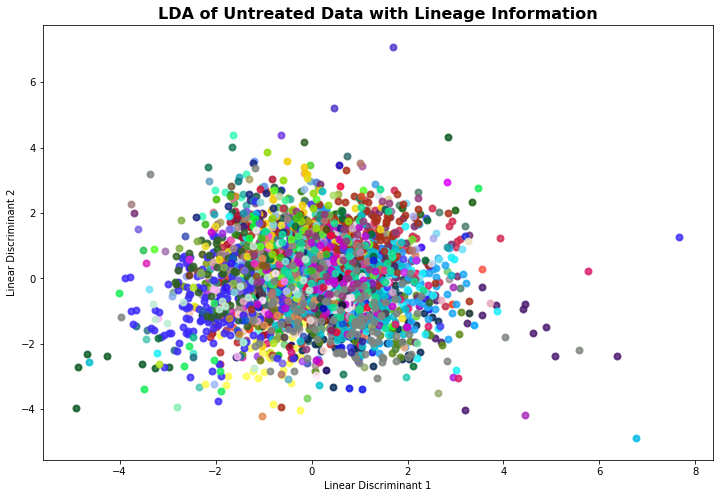

In [67]:
dims = (12,8)
fig,ax = plt.subplots(figsize=dims)

for color, i, bc_name in zip(colors, range(len(norm_bc_names_UU.unique())), norm_bc_names_UU.unique()):
    plt.scatter(norm_sc_values_r2_transform[norm_bc_names_numindexed_UU==i,0], 
                norm_sc_values_r2_transform[norm_bc_names_numindexed_UU==i,1], 
                color=color, alpha=0.8, lw=2, 
                label = bc_name)
# plt.ylim(-5,15)
# plt.legend(loc='lower left', shadow=False, scatterpoints=1, title = "Barcodes")
plt.xlabel("Linear Discriminant 1")
plt.ylabel("Linear Discriminant 2")
plt.title('LDA of Untreated Data with Lineage Information', fontsize = 16, weight = "bold")
# plt.savefig('LDA_untreated_lineage_norm.pdf')

In [79]:
top_bcs = sc_data_UU_norm['Barcode'].value_counts().head(10).index.values.tolist()

In [92]:
sc_data_UU_norm_reindex = sc_data_UU_norm.reset_index(drop=True)
sc_data_UT_norm_reindex = sc_data_UT_norm.reset_index(drop=True)

In [80]:
# Getting number of colors the length of unique barcodes
from random import randint
colors_top10 = []
lw = 2

for i in range(len(top_bcs)):
    colors_top10.append('#%06X' % randint(0, 0xFFFFFF))
    
colors_top10

['#1B6683',
 '#BCC9E5',
 '#3C024C',
 '#6C057B',
 '#A38A1F',
 '#8DEDC9',
 '#37FF63',
 '#1B3E78',
 '#8B9F0C',
 '#2C4CDB']

In [93]:
# Indexing barcodes so that you can color them on plot
norm_bc_names_UU = sc_data_UU_norm_reindex['Barcode']
norm_bc_names_UU_top10 = norm_bc_names_UU[norm_bc_names_UU.isin(top_bcs)]
norm_bc_names_top10_indexed_UU = norm_bc_names_UU_top10.astype('category')
norm_bc_names_top10_numindexed_UU = norm_bc_names_top10_indexed_UU.cat.codes

# Indexing barcodes so that you can color them on plot
norm_bc_names_UT = sc_data_UT_norm_reindex['Barcode']
norm_bc_names_UT_top10 = norm_bc_names_UT[norm_bc_names_UT.isin(top_bcs)]
norm_bc_names_top10_indexed_UT = norm_bc_names_UT_top10.astype('category')
norm_bc_names_top10_numindexed_UT = norm_bc_names_top10_indexed_UT.cat.codes

In [94]:
norm_sc_values_r2_transform_top10_UU = norm_sc_values_r2_transform[norm_bc_names_top10_numindexed_UU.index]
norm_sc_values_r2_transform_top10_UT = norm_sc_values_r2_transform_UT[norm_bc_names_top10_numindexed_UT.index]


In [85]:
barcode_color_df = pd.DataFrame({'Barcode': top_bcs,
                                 'Color': colors_top10})
barcode_color_df

Barcode    Color
0  CTGAGTCAGAGTGACACACT  #1B6683
1  CTGAGAGTGAGTCTGTCAGT  #BCC9E5
2  CTGAGTCACTCACTGAGTGT  #3C024C
3  CTGAGTGTGAGAGTGTGTGT  #6C057B
4  CTGACAGTGTCACACAGTGA  #A38A1F
5  CTGAGAGACTCTGTGACTGA  #8DEDC9
6  CTGAGACTCAGACAGACACT  #37FF63
7  CTGACTGTCAGACAGAGTGA  #1B3E78
8  CTGAGTCAGTCACACTCTGT  #8B9F0C
9  CTGACTGTCTGTCAGTGTGT  #2C4CDB

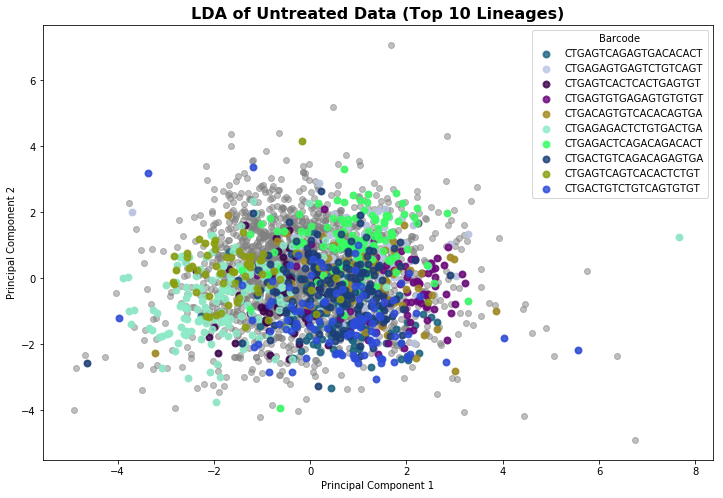

In [87]:
# Plot normalized data LDA with lineage information
% matplotlib inline

dims = (12,8)

fig,ax = plt.subplots(figsize=dims)

plt.scatter(norm_sc_values_r2_transform[:,0], norm_sc_values_r2_transform[:,1],
            color = 'grey', alpha = 0.5)


for color, i, bc_name in zip(colors_top10, range(len(barcode_color_df['Barcode'])), barcode_color_df['Barcode']):
    plt.scatter(norm_sc_values_r2_transform_top10_UU[norm_bc_names_top10_numindexed_UU==i,0], 
                norm_sc_values_r2_transform_top10_UU[norm_bc_names_top10_numindexed_UU==i,1], 
                color=color, alpha=0.8, lw=2, 
                label = bc_name)
plt.legend(loc='best', shadow=False, scatterpoints=1, title="Barcode")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title('LDA of Untreated Data (Top 10 Lineages)', fontsize = 16, weight = "bold")

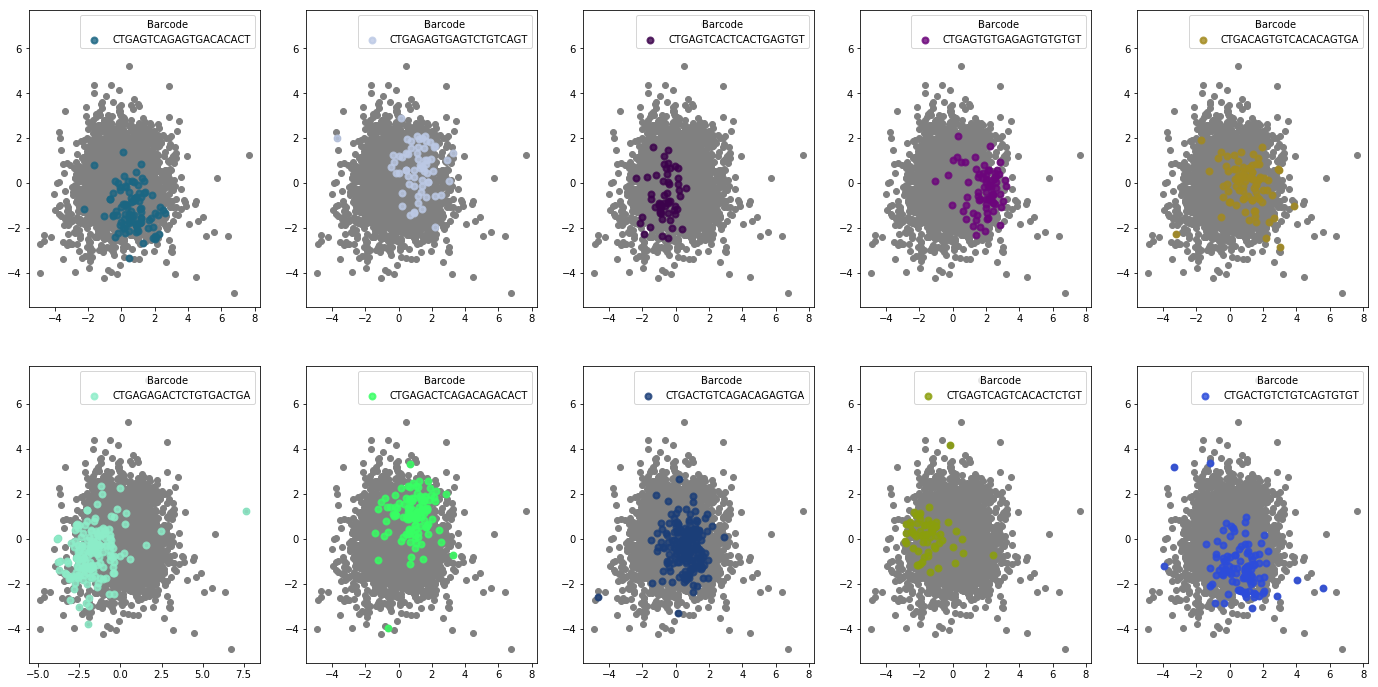

In [91]:
fig = plt.figure(figsize = (24,12))

for color, i, bc_name in zip(colors_top10, range(len(barcode_color_df['Barcode'])), barcode_color_df['Barcode']):
    ax = fig.add_subplot(2,5,i+1)
    plt.scatter(norm_sc_values_r2_transform[:,0], norm_sc_values_r2_transform[:,1], color = "grey")
    plt.scatter(norm_sc_values_r2_transform_top10_UU[norm_bc_names_top10_numindexed_UU==i,0], 
                norm_sc_values_r2_transform_top10_UU[norm_bc_names_top10_numindexed_UU==i,1], 
                color=color, alpha=0.8, lw=2, 
                label = bc_name)
#     print(bc_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1, title="Barcode")
plt.savefig("LDA_UU_lineageTop10_5x2.pdf")

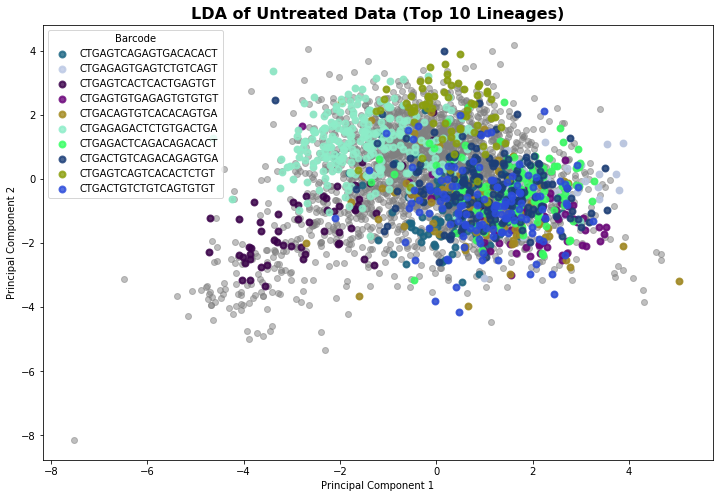

In [95]:
# Plot normalized data LDA with lineage information
% matplotlib inline

dims = (12,8)

fig,ax = plt.subplots(figsize=dims)

plt.scatter(norm_sc_values_r2_transform_UT[:,0], norm_sc_values_r2_transform_UT[:,1],
            color = 'grey', alpha = 0.5)


for color, i, bc_name in zip(colors_top10, range(len(barcode_color_df['Barcode'])), barcode_color_df['Barcode']):
    plt.scatter(norm_sc_values_r2_transform_top10_UT[norm_bc_names_top10_numindexed_UT==i,0], 
                norm_sc_values_r2_transform_top10_UT[norm_bc_names_top10_numindexed_UT==i,1], 
                color=color, alpha=0.8, lw=2, 
                label = bc_name)
plt.legend(loc='best', shadow=False, scatterpoints=1, title="Barcode")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title('LDA of Untreated Data (Top 10 Lineages)', fontsize = 16, weight = "bold")

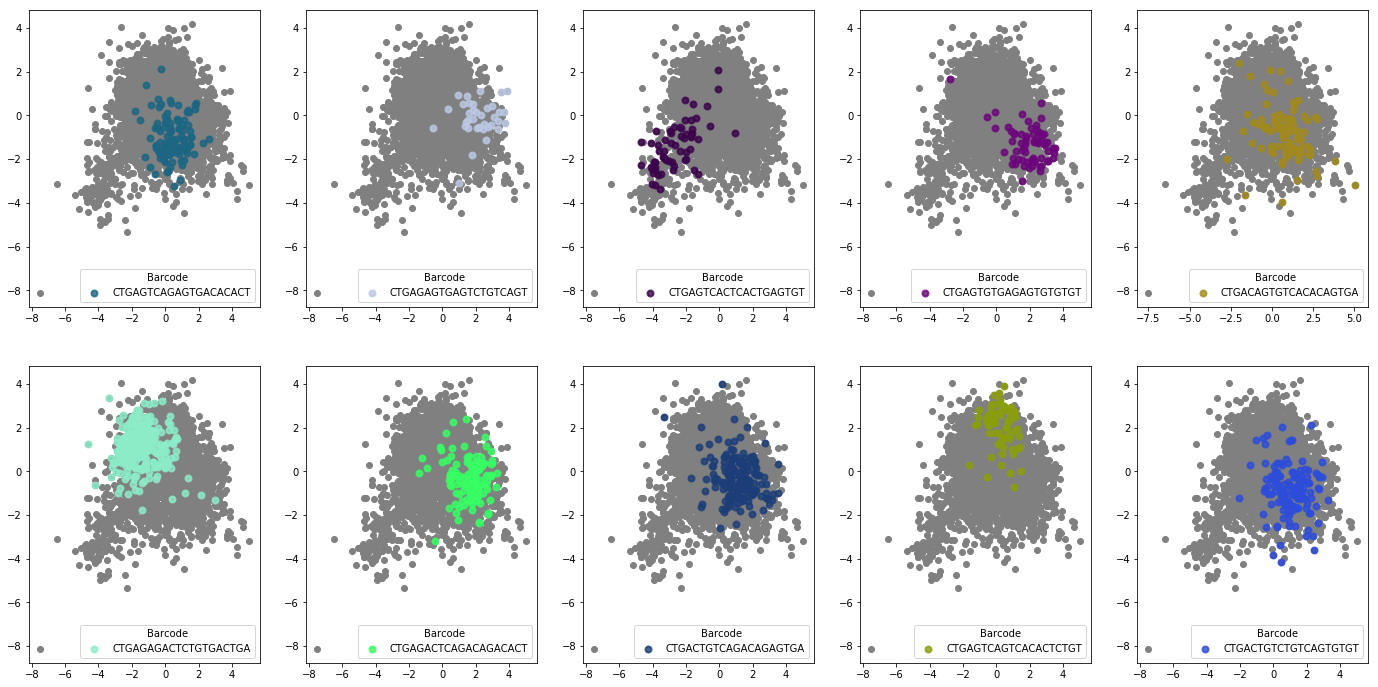

In [96]:
fig = plt.figure(figsize = (24,12))

for color, i, bc_name in zip(colors_top10, range(len(barcode_color_df['Barcode'])), barcode_color_df['Barcode']):
    ax = fig.add_subplot(2,5,i+1)
    plt.scatter(norm_sc_values_r2_transform_UT[:,0], norm_sc_values_r2_transform_UT[:,1], color = "grey")
    plt.scatter(norm_sc_values_r2_transform_top10_UT[norm_bc_names_top10_numindexed_UT==i,0], 
                norm_sc_values_r2_transform_top10_UT[norm_bc_names_top10_numindexed_UT==i,1], 
                color=color, alpha=0.8, lw=2, 
                label = bc_name)
#     print(bc_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1, title="Barcode")
plt.savefig("LDA_UT_lineageTop10_5x2.pdf")

In [68]:
# Indexing barcodes so that you can color them on plot
norm_bc_names_UT = sc_data_UT_norm['Barcode']
norm_bc_names_indexed_UT = norm_bc_names_UT.astype('category')
norm_bc_names_numindexed_UT = norm_bc_names_indexed_UT.cat.codes
norm_bc_names_indexed_UT.value_counts().head()

CTGAGAGTGAGTCTGTCAGT    258
CTGAGTCAGAGTGACACACT    176
CTGACAGACACTCTCAGTCT    139
CTGAGTGTGAGAGTGTGTGT    130
CTGAGTCACTCACTGAGTGT    125
Name: Barcode, dtype: int64

In [69]:
# Getting number of colors the length of unique barcodes
from random import randint
colors1 = []
lw = 2

for i in range(len(norm_bc_names_UT.unique())):
    colors1.append('#%06X' % randint(0, 0xFFFFFF))
    
colors1

['#02658F',
 '#94C9B2',
 '#AC3353',
 '#C3E865',
 '#E48D44',
 '#5598DA',
 '#992CB3',
 '#4D2390',
 '#FCE6E6',
 '#C908AD',
 '#7F02EC',
 '#A93CAD',
 '#B7A2B3',
 '#0EBA52',
 '#9B33BD',
 '#39A846',
 '#3A111F',
 '#813A45',
 '#5A2074',
 '#9B82FC',
 '#51A543',
 '#45AAEC',
 '#B58426',
 '#2155E5',
 '#E1E074',
 '#85E5F9',
 '#F04708',
 '#171394',
 '#92CBD5',
 '#B64C68',
 '#B2776A',
 '#B49040',
 '#FC56ED',
 '#7755E3',
 '#BCECBD',
 '#FC7956',
 '#7C4D3C',
 '#897F62',
 '#D78A03',
 '#5573F6',
 '#A81726',
 '#872284',
 '#865171',
 '#B9D1F1',
 '#BD77B5',
 '#FB316A',
 '#42BCE2',
 '#0595BC',
 '#390024',
 '#D02623',
 '#4F5CFC',
 '#FC96F5',
 '#E8D0B4',
 '#BFFF08',
 '#115A38',
 '#03E75C',
 '#06815F',
 '#0573EE',
 '#2C8110',
 '#E8192A',
 '#04B88B',
 '#62EAFE',
 '#FB5571',
 '#CC74E6',
 '#7D7481',
 '#E6740F',
 '#492FA4',
 '#2EAA2A',
 '#F4BD89',
 '#477AA2',
 '#7FA7DE',
 '#0D3E7F',
 '#A21447',
 '#11C3B6',
 '#4D804B',
 '#953841',
 '#E16342',
 '#0CCE73',
 '#36254B',
 '#A3C50B',
 '#1E6494',
 '#01ECFD',
 '#A467D4',
 '#9

In [70]:
# Linear Discriminant Analysis (LDA) with normalized data and lineage information
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda_norm = LDA(n_components=2)
norm_sc_values_r2_transform_UT = lda_norm.fit(sc_data_UT_norm.iloc[:,5:], norm_bc_names_numindexed_UT).transform(sc_data_UT_norm.iloc[:,5:])


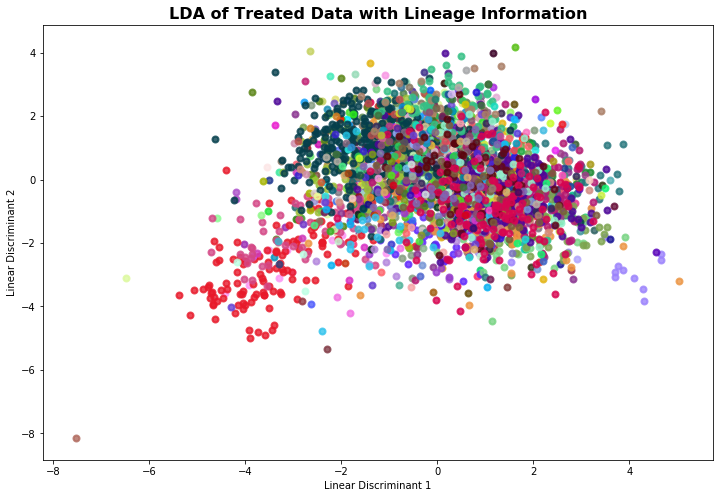

In [71]:
dims = (12,8)
fig,ax = plt.subplots(figsize=dims)

for color, i, bc_name in zip(colors1, range(len(norm_bc_names_UT.unique())), norm_bc_names_UT.unique()):
    plt.scatter(norm_sc_values_r2_transform_UT[norm_bc_names_numindexed_UT==i,0], 
                norm_sc_values_r2_transform_UT[norm_bc_names_numindexed_UT==i,1], 
                color=color, alpha=0.8, lw=2, 
                label = bc_name)
# plt.ylim(-5,15)
# plt.legend(loc='lower left', shadow=False, scatterpoints=1, title = "Barcodes")
plt.xlabel("Linear Discriminant 1")
plt.ylabel("Linear Discriminant 2")
plt.title('LDA of Treated Data with Lineage Information', fontsize = 16, weight = "bold")
# plt.savefig('LDA_untreated_lineage_norm.pdf')

In [98]:
from sklearn.decomposition import PCA

# Principal Component Analysis (10 components, to be followed by t-SNE) of normalized data - Untreated
norm_pca_10comp_UU = PCA(n_components=10) # Copying 10x and ScanPy 
norm_sc_values_r_10comp_UU = norm_pca_10comp_UU.fit(sc_data_UU_norm.iloc[:,5:])
norm_sc_values_r_transform_10comp_UU = norm_pca_10comp_UU.fit(sc_data_UU_norm.iloc[:,5:]).transform(sc_data_UU_norm.iloc[:,5:])

# Principal Component Analysis (10 components, to be followed by t-SNE) of normalized data - Untreated
norm_pca_10comp_UT = PCA(n_components=10) # Copying 10x and ScanPy 
norm_sc_values_r_10comp_UT = norm_pca_10comp_UT.fit(sc_data_UT_norm.iloc[:,5:])
norm_sc_values_r_transform_10comp_UT = norm_pca_10comp_UT.fit(sc_data_UT_norm.iloc[:,5:]).transform(sc_data_UT_norm.iloc[:,5:])


In [99]:
# t-SNE on 10 component PCA of normalized data
from MulticoreTSNE import MulticoreTSNE as TSNE
import time as time
perplexities = [5,10,15,20,25,30,35,40,45,50]


tsne_norm_10comp_diffperp_results_UU = []
for perp in perplexities:
    time_start = time.time()
    tsne_norm_10comp_diffperp_UU = TSNE(n_components=2, verbose=1, perplexity=perp, n_iter=1000, n_jobs=8)
    tsne_norm_10comp_diffperp_results_UU.append(tsne_norm_10comp_diffperp_UU.fit_transform(norm_sc_values_r_transform_10comp_UU))
    print
    print 't-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start)
    
tsne_norm_10comp_diffperp_results_UT = []
for perp in perplexities:
    time_start = time.time()
    tsne_norm_10comp_diffperp_UT = TSNE(n_components=2, verbose=1, perplexity=perp, n_iter=1000, n_jobs=8)
    tsne_norm_10comp_diffperp_results_UT.append(tsne_norm_10comp_diffperp_UT.fit_transform(norm_sc_values_r_transform_10comp_UT))
    print
    print 't-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start)


t-SNE done! Time elapsed: 16.5259199142 seconds

t-SNE done! Time elapsed: 16.5149879456 seconds

t-SNE done! Time elapsed: 16.8688230515 seconds

t-SNE done! Time elapsed: 17.4662408829 seconds

t-SNE done! Time elapsed: 19.4983289242 seconds

t-SNE done! Time elapsed: 18.6709489822 seconds

t-SNE done! Time elapsed: 18.6142041683 seconds

t-SNE done! Time elapsed: 21.6911351681 seconds

t-SNE done! Time elapsed: 21.6973540783 seconds

t-SNE done! Time elapsed: 25.0594911575 seconds

t-SNE done! Time elapsed: 21.2063009739 seconds

t-SNE done! Time elapsed: 20.5821340084 seconds

t-SNE done! Time elapsed: 22.0941169262 seconds

t-SNE done! Time elapsed: 21.8409638405 seconds

t-SNE done! Time elapsed: 22.1649279594 seconds

t-SNE done! Time elapsed: 23.0892729759 seconds

t-SNE done! Time elapsed: 23.0057759285 seconds

t-SNE done! Time elapsed: 25.5810120106 seconds

t-SNE done! Time elapsed: 25.702080965 seconds

t-SNE done! Time elapsed: 25.5970339775 seconds


In [100]:
p=6 # perplexity = 35
tsne_norm_10comp_perp35_UU = tsne_norm_10comp_diffperp_results_UU[p][norm_bc_names_top10_numindexed_UU.index]
tsne_norm_10comp_perp35_UT = tsne_norm_10comp_diffperp_results_UT[p][norm_bc_names_top10_numindexed_UT.index]


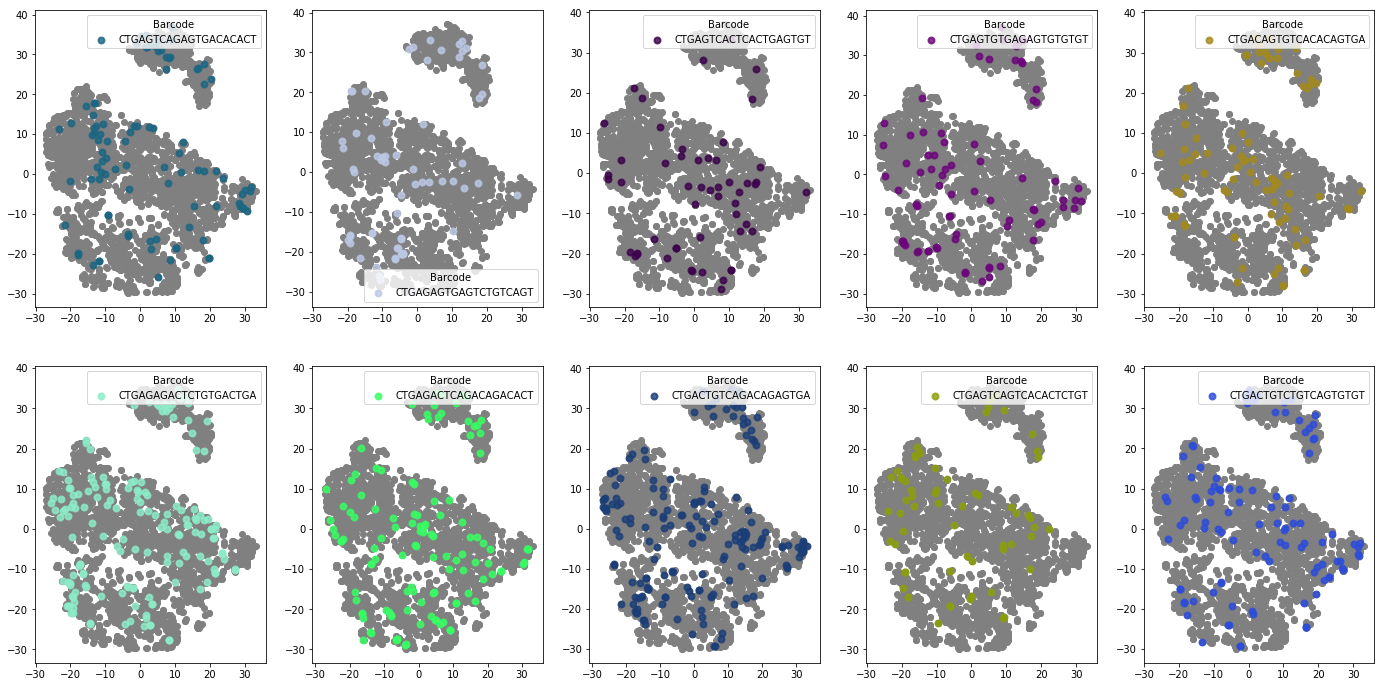

In [102]:
fig = plt.figure(figsize = (24,12))

for color, i, bc_name in zip(colors_top10, range(len(barcode_color_df['Barcode'])), barcode_color_df['Barcode']):
    ax = fig.add_subplot(2,5,i+1)
    plt.scatter(tsne_norm_10comp_diffperp_results_UU[p][:,0], tsne_norm_10comp_diffperp_results_UU[p][:,1], color = "grey")
    plt.scatter(tsne_norm_10comp_perp35_UU[norm_bc_names_top10_numindexed_UU==i,0], 
                tsne_norm_10comp_perp35_UU[norm_bc_names_top10_numindexed_UU==i,1], 
                color=color, alpha=0.8, lw=2, 
                label = bc_name)
#     print(bc_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1, title="Barcode")
plt.savefig("PCA-tSNE_UU_lineageTop10_5x2.pdf")

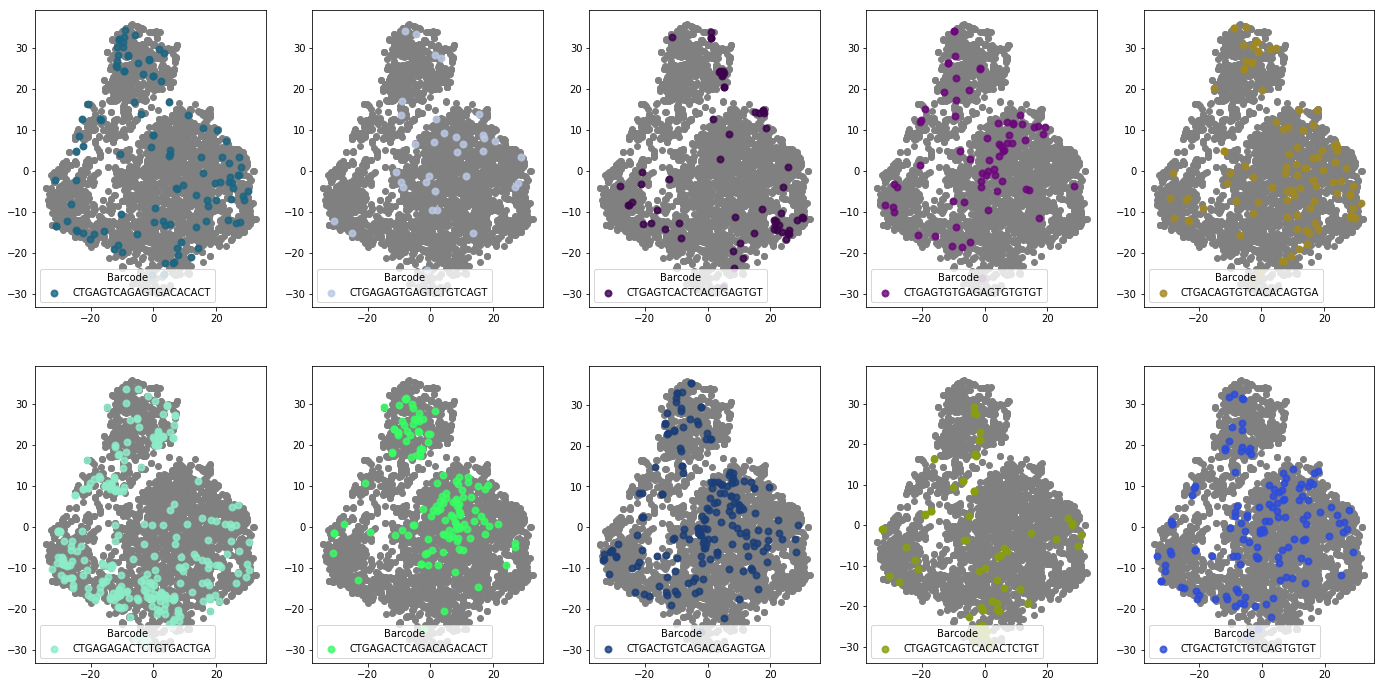

In [103]:
fig = plt.figure(figsize = (24,12))

for color, i, bc_name in zip(colors_top10, range(len(barcode_color_df['Barcode'])), barcode_color_df['Barcode']):
    ax = fig.add_subplot(2,5,i+1)
    plt.scatter(tsne_norm_10comp_diffperp_results_UT[p][:,0], tsne_norm_10comp_diffperp_results_UT[p][:,1], color = "grey")
    plt.scatter(tsne_norm_10comp_perp35_UT[norm_bc_names_top10_numindexed_UT==i,0], 
                tsne_norm_10comp_perp35_UT[norm_bc_names_top10_numindexed_UT==i,1], 
                color=color, alpha=0.8, lw=2, 
                label = bc_name)
#     print(bc_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1, title="Barcode")
plt.savefig("PCA-tSNE_UT_lineageTop10_5x2.pdf")

In [35]:
# Principal Component Analysis (10 components, to be followed by t-SNE) of normalized data
norm_pca_10comp = PCA(n_components=10) # Copying 10x and ScanPy 
norm_sc_values_r_10comp = norm_pca_10comp.fit(sc_data_UT_norm.iloc[:,4:])
norm_sc_values_r_transform_10comp = norm_pca_10comp.fit(sc_data_UT_norm.iloc[:,4:]).transform(sc_data_UT_norm.iloc[:,4:])

In [36]:
norm_sc_values_r_transform_10comp

array([[ 35.19981829,  18.26052244,   5.16814856, ...,   3.07524908,
          5.05393049,  -4.66563522],
       [ 25.43812108,  15.76022486,  10.01984384, ...,   3.54858038,
          7.50597943,  -8.84323538],
       [ 25.27121695,   2.96633661,  19.13740281, ...,  -3.06764026,
          0.18085268,  -5.31411852],
       ..., 
       [  6.89414209,  12.12076014,  -5.88849258, ...,  -0.23266236,
          6.4712125 ,  -3.92041227],
       [-10.85051198,  -6.72500297,   1.08406777, ...,  -1.81865739,
          3.2844434 ,   5.86685714],
       [  8.58877553, -14.66174788,  -5.27916877, ...,   3.17142273,
          2.26430305,  -4.81261985]])

In [37]:
# t-SNE on 10 component PCA of normalized data
from MulticoreTSNE import MulticoreTSNE as TSNE
import time as time

tsne_norm_10comp_diffperp_results = []
perplexities = [5,10,15,20,25,30,35,40,45,50]
for perp in perplexities:
    time_start = time.time()
    tsne_norm_10comp_diffperp = TSNE(n_components=2, verbose=1, perplexity=perp, n_iter=1000, n_jobs=8)
    tsne_norm_10comp_diffperp_results.append(tsne_norm_10comp_diffperp.fit_transform(norm_sc_values_r_transform_10comp))
    print
    print 't-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start)


t-SNE done! Time elapsed: 22.4877820015 seconds

t-SNE done! Time elapsed: 21.9575579166 seconds

t-SNE done! Time elapsed: 22.635461092 seconds

t-SNE done! Time elapsed: 23.1686651707 seconds

t-SNE done! Time elapsed: 24.3801600933 seconds

t-SNE done! Time elapsed: 24.0804579258 seconds

t-SNE done! Time elapsed: 25.0205729008 seconds

t-SNE done! Time elapsed: 25.3276708126 seconds

t-SNE done! Time elapsed: 26.4951140881 seconds

t-SNE done! Time elapsed: 28.9786400795 seconds


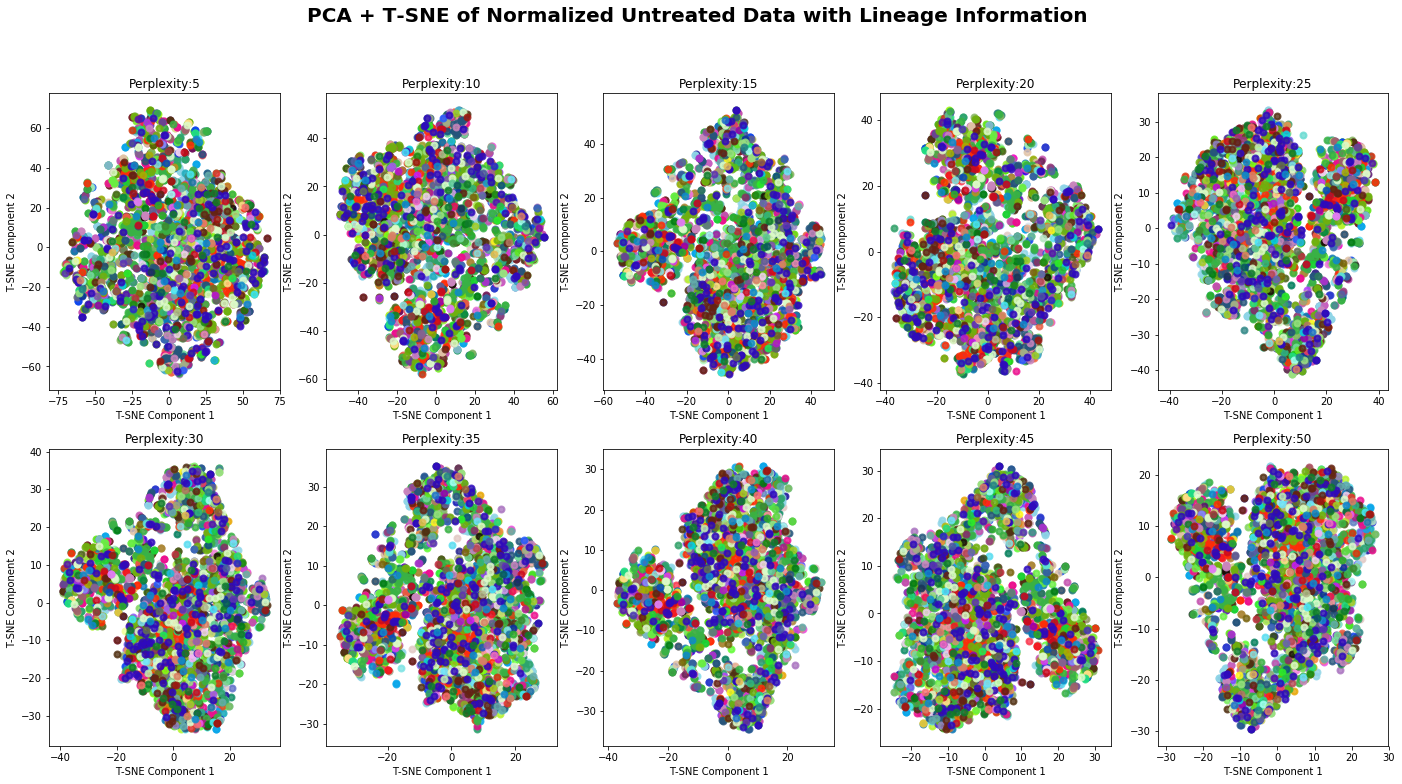

In [38]:
# Plotting normalized data PCA + t-SNE with lineage information. Different boxes have different 
# t-SNE perplexities - see powerpoint for detailed discussion of why that matters

%matplotlib inline

fig = plt.figure(figsize = (24,12))
fig.suptitle("PCA + T-SNE of Normalized Untreated Data with Lineage Information", fontsize = 20, weight = "bold")
for p in range(len(tsne_norm_10comp_diffperp_results)):
    ax = fig.add_subplot(2,5,p+1)
    ax.set_title("Perplexity:" + str(perplexities[p]))
    ax.set_xlabel("T-SNE Component 1")
    ax.set_ylabel("T-SNE Component 2")
    for color, i, bc_name in zip(colors, range(len(norm_bc_names.unique())), norm_bc_names.unique()):
        plt.scatter(tsne_norm_10comp_diffperp_results[p][norm_bc_names_numindexed==i,0], 
                    tsne_norm_10comp_diffperp_results[p][norm_bc_names_numindexed==i,1], 
                    color=color, alpha=0.8, lw=2, 
                    label = bc_name)
plt.savefig("TSNE+PCA_diffperp_UT.pdf")

In [39]:
# Take top10 highest prevalence lineage barcodes
subset_highLB = norm_bc_names_indexed.value_counts().head(10).index.tolist()
subset_highLB

['CTGAGAGTGAGTCTGTCAGT',
 'CTGAGTCAGAGTGACACACT',
 'CTGACAGACACTCTCAGTCT',
 'CTGAGTGTGAGAGTGTGTGT',
 'CTGAGTCACTCACTGAGTGT',
 'CTGACAGTGTCACACAGTGA',
 'CTGAGAGACTCTGTGACTGA',
 'CTGAGAGTCACTGAGTGTGT',
 'CTGAGTCAGTCACACTCTGT',
 'CTGAGACTCAGACAGACACT']

In [41]:
# Subset data by the above lineage barcodes
sc_data_UT_norm_top10LB = sc_data_UT_norm[sc_data_UT_norm['Barcode'].isin(subset_highLB)]
sc_data_UT_norm_top10LB.shape

(1240, 15174)

In [43]:
sc_data_UT_norm_top10LB.head()

Barcode      Cell Barcode         UMI WASH7P  LOC100288069  \
5   CTGAGTCAGAGTGACACACT  TCAGCTCGTCACTTCC  ATCACTACTT      0           0.0   
6   CTGAGAGTGAGTCTGTCAGT  AGCGGTCAGCGACGTA  TTATCTCCCG      0           0.0   
12  CTGAGAGTGAGTCTGTCAGT  TGTGTTTAGACCGGAT  CGGCATGTAA      0           0.0   
13  CTGAGTCAGAGTGACACACT  CGTTGGGAGATCTGCT  TCTTTATGTT      0           0.0   
14  CTGAGAGTCACTGAGTGTGT  ATCCACCTCTCGTATT  GGATTTCCAT      0           0.0   

    FAM87B  LINC00115  LINC01128  FAM41C  SAMD11  ...   MTCP1  BRCC3  \
5      0.0        0.0   0.000000     0.0     0.0  ...     0.0    0.0   
6      0.0        0.0   1.265316     0.0     0.0  ...     0.0    0.0   
12     0.0        0.0   0.000000     0.0     0.0  ...     0.0    0.0   
13     0.0        0.0   0.000000     0.0     0.0  ...     0.0    0.0   
14     0.0        0.0   0.000000     0.0     0.0  ...     0.0    0.0   

        VBP1  RAB39B  CLIC2     TMLHE  SPRY3     VAMP7  PCDH11Y  CD24  
5   1.571757     0.0    0.0  0.000000    0.0  0.000000      0.0   0.0  
6   1.958464     0.0    0.0  1.265316    0.0  1.265316      0.0   0.0  
12  2.675220     0.0    0.0  0.000000    0.0  0.000000      0.0   0.0  
13  1.166677     0.0    0.0  0.000000    0.0  0.000000      0.0   0.0  
14  1.160849     0.0    0.0  0.000000    0.0  0.000000      0.0   0.0  

[5 rows x 15174 columns]

In [44]:
sc_data_UT_norm_top10LB['Barcode'].unique()

array(['CTGAGTCAGAGTGACACACT', 'CTGAGAGTGAGTCTGTCAGT',
       'CTGAGAGTCACTGAGTGTGT', 'CTGAGTGTGAGAGTGTGTGT',
       'CTGACAGACACTCTCAGTCT', 'CTGAGACTCAGACAGACACT',
       'CTGAGAGACTCTGTGACTGA', 'CTGACAGTGTCACACAGTGA',
       'CTGAGTCACTCACTGAGTGT', 'CTGAGTCAGTCACACTCTGT'], dtype=object)

In [46]:
# Getting number of colors the length of unique barcodes
from random import randint
colors1 = []
lw = 2

for i in range(len(sc_data_UT_norm_top10LB['Barcode'].unique())):
    colors1.append('#%06X' % randint(0, 0xFFFFFF))
    
colors1

['#258699',
 '#3763FA',
 '#0AB7FF',
 '#F637C6',
 '#6F98D1',
 '#A5D875',
 '#F389B7',
 '#E88607',
 '#32262B',
 '#1C6B78']

In [47]:
# Principal Component Analysis with T-SNE
norm_pca_top10_10comp = PCA(n_components=10) # Copying 10x and ScanPy 
norm_sc_values_r_top10_10comp = norm_pca_top10_10comp.fit(sc_data_UT_norm_top10LB.iloc[:,4:])
norm_sc_values_r_transform_top10_10comp = norm_pca_top10_10comp.fit(sc_data_UT_norm_top10LB.iloc[:,4:]).transform(sc_data_UT_norm_top10LB.iloc[:,4:])



In [48]:
from MulticoreTSNE import MulticoreTSNE as TSNE
import time as time

tsne_norm_top10_10comp_diffperp_results = []
perplexities = [5,10,15,20,25,30,35,40,45,50]
for perp in perplexities:
    time_start = time.time()
    tsne_norm_top10_10comp_diffperp = TSNE(n_components=2, verbose=1, perplexity=perp, n_iter=1000, n_jobs=8)
    tsne_norm_top10_10comp_diffperp_results.append(tsne_norm_top10_10comp_diffperp.fit_transform(norm_sc_values_r_transform_top10_10comp))
    print
    print 't-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start)


t-SNE done! Time elapsed: 7.72924804688 seconds

t-SNE done! Time elapsed: 7.53335213661 seconds

t-SNE done! Time elapsed: 7.57883405685 seconds

t-SNE done! Time elapsed: 7.73974609375 seconds

t-SNE done! Time elapsed: 7.78512096405 seconds

t-SNE done! Time elapsed: 8.05843019485 seconds

t-SNE done! Time elapsed: 8.31439304352 seconds

t-SNE done! Time elapsed: 8.78318095207 seconds

t-SNE done! Time elapsed: 9.68539094925 seconds

t-SNE done! Time elapsed: 10.3701901436 seconds


In [49]:
# Indexing barcodes so that you can color them on plot
norm_bc_names_top10 = sc_data_UT_norm_top10LB['Barcode']
norm_bc_names_top10_indexed = norm_bc_names_top10.astype('category')
norm_bc_names_top10_numindexed = norm_bc_names_top10_indexed.cat.codes
norm_bc_names_top10_indexed.value_counts()

CTGAGAGTGAGTCTGTCAGT    258
CTGAGTCAGAGTGACACACT    176
CTGACAGACACTCTCAGTCT    139
CTGAGTGTGAGAGTGTGTGT    130
CTGAGTCACTCACTGAGTGT    125
CTGACAGTGTCACACAGTGA    109
CTGAGAGACTCTGTGACTGA     97
CTGAGAGTCACTGAGTGTGT     71
CTGAGTCAGTCACACTCTGT     68
CTGAGACTCAGACAGACACT     67
Name: Barcode, dtype: int64

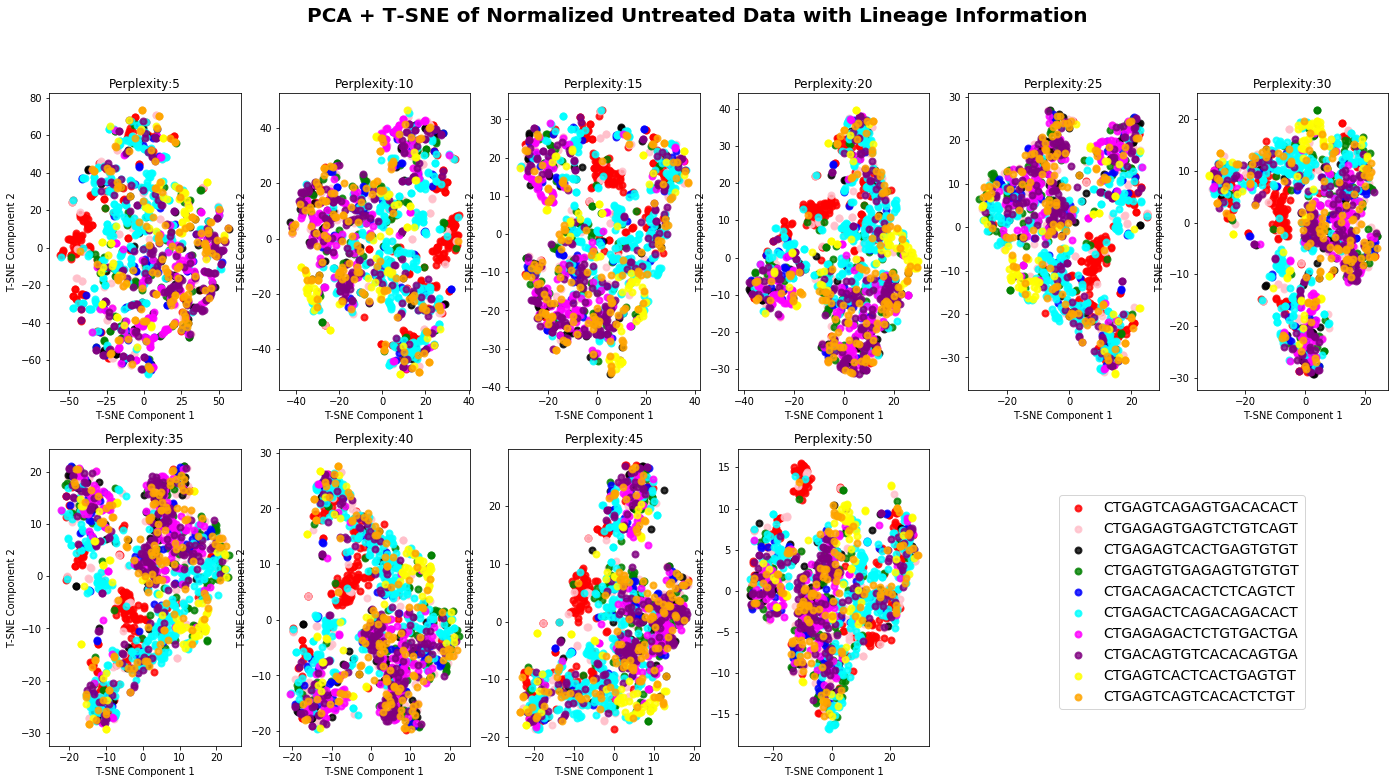

In [50]:
%matplotlib inline

colors1 = ['red', 'pink', 'black', 'green', 'blue',
          'aqua', 'magenta', 'purple', 'yellow', 'orange']

fig = plt.figure(figsize = (24,12))
fig.suptitle("PCA + T-SNE of Normalized Untreated Data with Lineage Information", fontsize = 20, weight = "bold")
for p in range(len(tsne_norm_top10_10comp_diffperp_results)):
    ax = fig.add_subplot(2,6,p+1)
    ax.set_title("Perplexity:" + str(perplexities[p]))
    ax.set_xlabel("T-SNE Component 1")
    ax.set_ylabel("T-SNE Component 2")
    for color, i, bc_name in zip(colors1, range(len(norm_bc_names_top10.unique())), norm_bc_names_top10.unique()):
        plt.scatter(tsne_norm_top10_10comp_diffperp_results[p][norm_bc_names_top10_numindexed==i,0], 
                    tsne_norm_top10_10comp_diffperp_results[p][norm_bc_names_top10_numindexed==i,1], 
                    color=color, alpha=0.8, lw=2, 
                    label = bc_name)
plt.legend(loc = "lower right", bbox_to_anchor = (1,0.10,2,1), prop={'size':14})
plt.savefig("UT_top10_Norm_PCA+TSNE_diffperp.pdf")

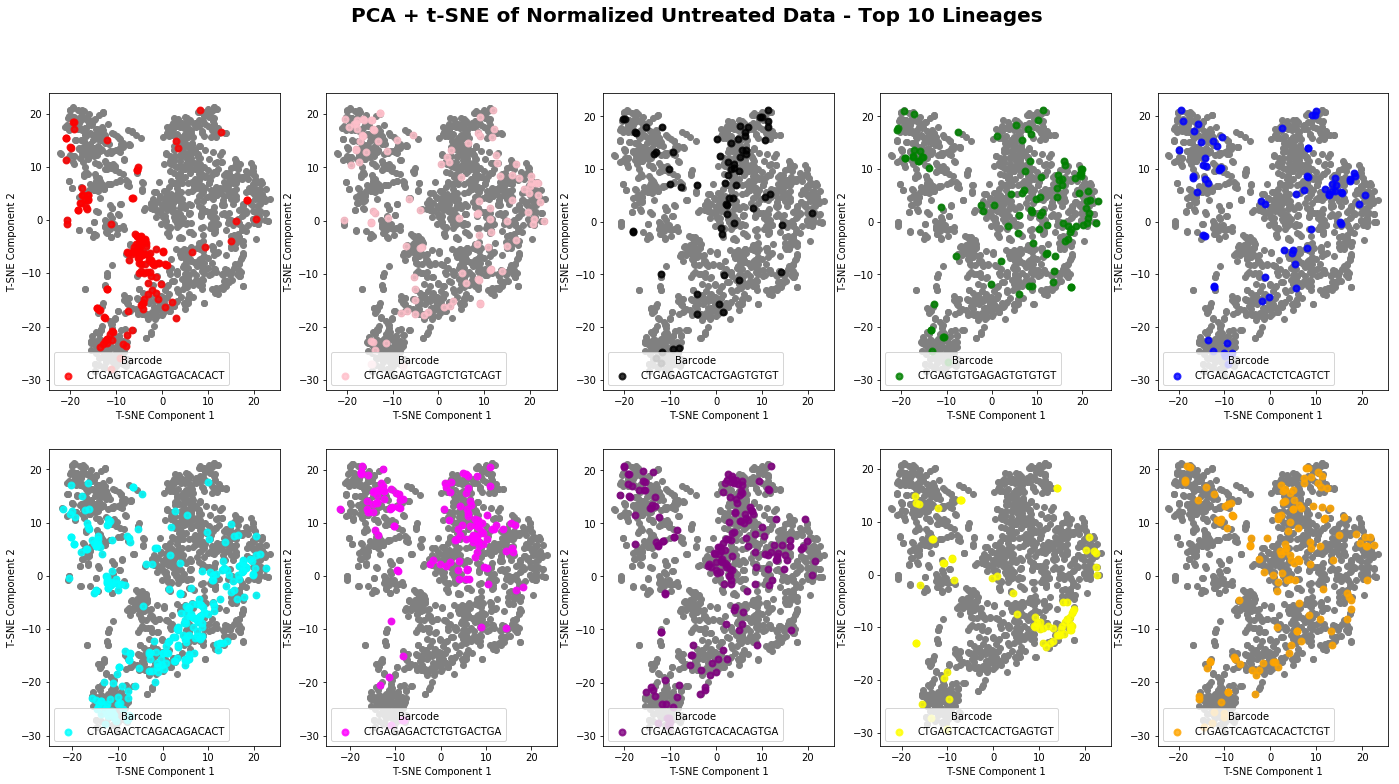

In [52]:
fig = plt.figure(figsize = (24,12))
fig.suptitle("PCA + t-SNE of Normalized Untreated Data - Top 10 Lineages", fontsize = 20, weight = "bold")

p = 6

for color, i, bc_name in zip(colors1, range(len(norm_bc_names_top10.unique())), norm_bc_names_top10.unique()):
    ax = fig.add_subplot(2,5,i+1)
#     ax.set_title("Perplexity:" + str(perplexities[p]))
    ax.set_xlabel("T-SNE Component 1")
    ax.set_ylabel("T-SNE Component 2")
    plt.scatter(tsne_norm_top10_10comp_diffperp_results[p][:,0], tsne_norm_top10_10comp_diffperp_results[p][:,1], color = "grey")
    plt.scatter(tsne_norm_top10_10comp_diffperp_results[p][norm_bc_names_top10_numindexed==i,0], 
                tsne_norm_top10_10comp_diffperp_results[p][norm_bc_names_top10_numindexed==i,1], 
                color=color, alpha=0.8, lw=2, 
                label = bc_name)
    plt.legend(loc='lower left', shadow=False, scatterpoints=1, title = "Barcode")

plt.savefig('UT_PCA+tSNE_perp35_wlineage_Norm_5x2.pdf')

In [53]:
# Principal Component Analysis
norm_pca_top10 = PCA(n_components=2)
norm_sc_values_r_top10 = norm_pca_top10.fit(sc_data_UT_norm_top10LB.iloc[:,4:])
norm_sc_values_r_top10_transform = norm_pca_top10.fit(sc_data_UT_norm_top10LB.iloc[:,4:]).transform(sc_data_UT_norm_top10LB.iloc[:,4:])

explained variance ratio (first two components): [ 0.03413856  0.01547197]


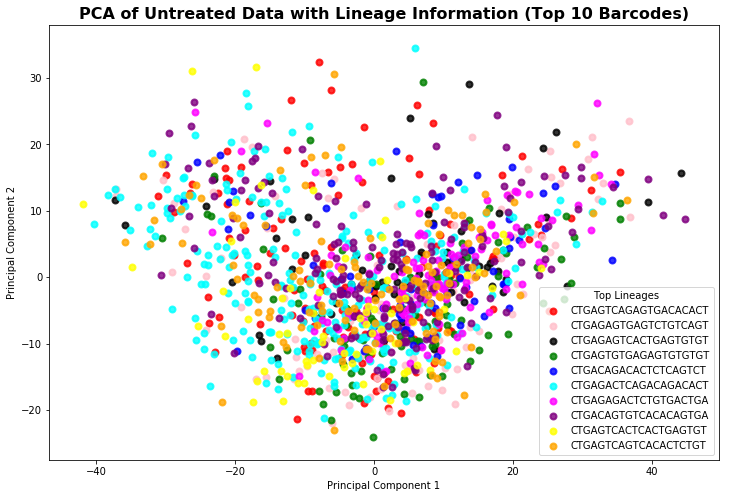

In [54]:
# Plot top10 lineages PCA with lineage information
% matplotlib inline

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(norm_pca_top10.explained_variance_ratio_))

dims = (12,8)

fig,ax = plt.subplots(figsize=dims)

colors1 = ['red', 'pink', 'black', 'green', 'blue',
          'aqua', 'magenta', 'purple', 'yellow', 'orange']

# print(colors1)
# print(range(len(test_bc_names_top10.unique())))
# print(test_bc_names_top10.unique())
# print(zip(colors1, range(len(test_bc_names_top10.unique())), test_bc_names_top10.unique()))

for color, i, bc_name in zip(colors1, range(len(norm_bc_names_top10.unique())), norm_bc_names_top10.unique()):
    plt.scatter(norm_sc_values_r_top10_transform[norm_bc_names_top10_numindexed==i,0], 
                norm_sc_values_r_top10_transform[norm_bc_names_top10_numindexed==i,1], 
                color=color, alpha=0.8, lw=2, 
                label = bc_name)
#     print(bc_name)
plt.legend(loc='best', shadow=False, scatterpoints=1, title="Top Lineages")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title('PCA of Untreated Data with Lineage Information (Top 10 Barcodes)', fontsize = 16, weight = "bold")
plt.savefig('UT_PCA_lineage_norm_top10.pdf')

explained variance ratio (first two components): [ 0.03413856  0.01547197]


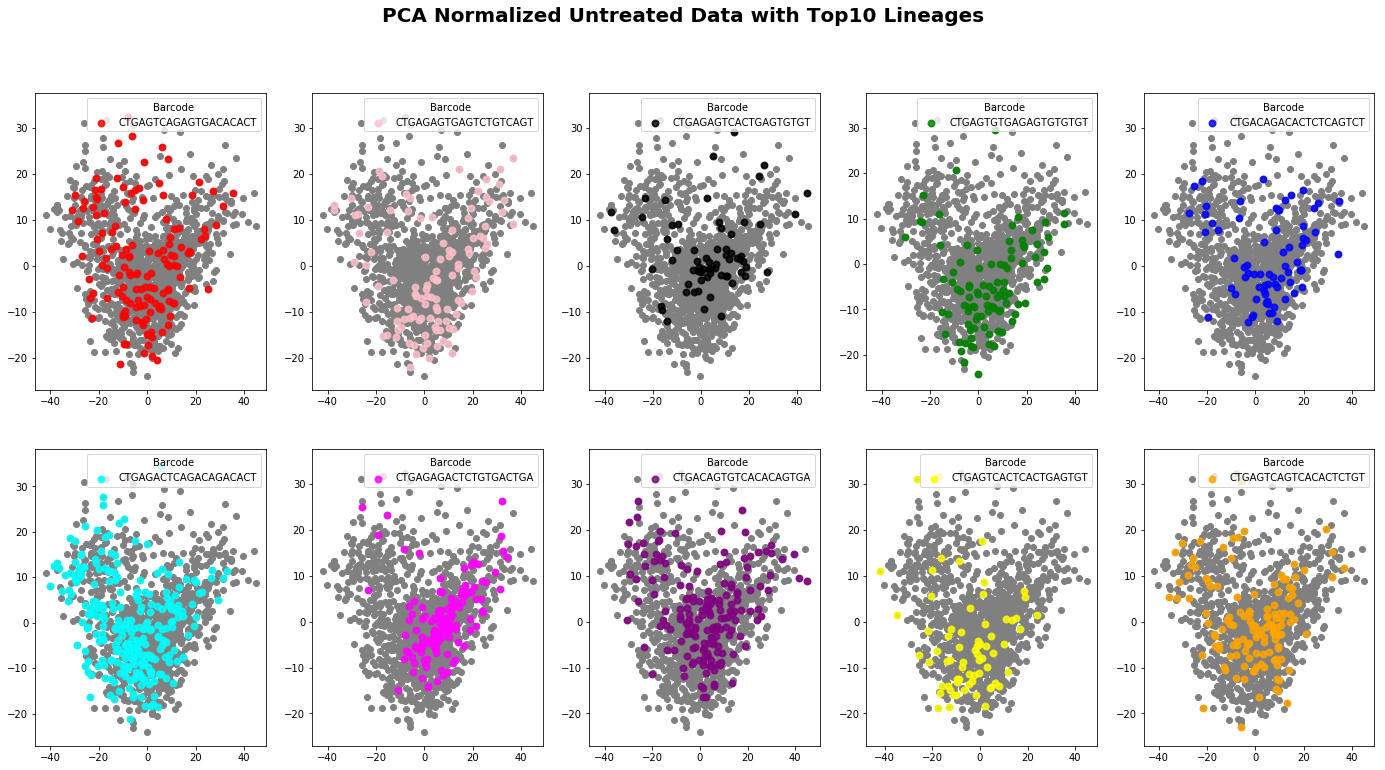

In [56]:
# Plot top10 lineages PCA with lineage information
% matplotlib inline

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(norm_pca_top10.explained_variance_ratio_))

colors1 = ['red', 'pink', 'black', 'green', 'blue',
          'aqua', 'magenta', 'purple', 'yellow', 'orange']

fig = plt.figure(figsize = (24,12))
fig.suptitle("PCA Normalized Untreated Data with Top10 Lineages", fontsize = 20, weight = "bold")

for color, i, bc_name in zip(colors1, range(len(norm_bc_names_top10.unique())), norm_bc_names_top10.unique()):
    ax = fig.add_subplot(2,5,i+1)
    plt.scatter(norm_sc_values_r_top10_transform[:,0], norm_sc_values_r_top10_transform[:,1], color = "grey")
    plt.scatter(norm_sc_values_r_top10_transform[norm_bc_names_top10_numindexed==i,0], 
                norm_sc_values_r_top10_transform[norm_bc_names_top10_numindexed==i,1], 
                color=color, alpha=0.8, lw=2, 
                label = bc_name)
#     print(bc_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1, title="Barcode")
plt.savefig("UT_PCA_untreated_lineage_norm_5x2.pdf")

In [61]:
bc_values['Barcode'].value_counts().to_csv('UT_bcCounts.csv')

In [2]:
import pandas as pd

In [52]:
UU_bcCounts = pd.read_csv('UU_bcCounts.csv', header = None)
UU_bcCounts.columns = ['Barcode_UU', 'Count_UU']
UU_bcCounts.head()

Barcode_UU  Count_UU
0  CTGAGTCAGAGTGACACACT       176
1  CTGAGAGTGAGTCTGTCAGT       161
2  CTGAGTCACTCACTGAGTGT       118
3  CTGAGTGTGAGAGTGTGTGT       103
4  CTGACAGTGTCACACAGTGA        95

In [53]:
UT_bcCounts = pd.read_csv('UT_bcCounts.csv', header = None)
UT_bcCounts.columns = ['Barcode_UT', 'Count_UT']
UT_bcCounts.head()

Barcode_UT  Count_UT
0  CTGAGAGTGAGTCTGTCAGT       258
1  CTGAGTCAGAGTGACACACT       176
2  CTGACAGACACTCTCAGTCT       139
3  CTGAGTGTGAGAGTGTGTGT       130
4  CTGAGTCACTCACTGAGTGT       125

In [54]:
bcCountCompare = UU_bcCounts.merge(UT_bcCounts, left_on='Barcode_UU', right_on='Barcode_UT', how='outer')
bcCountCompare.head()

Barcode_UU  Count_UU            Barcode_UT  Count_UT
0  CTGAGTCAGAGTGACACACT     176.0  CTGAGTCAGAGTGACACACT     176.0
1  CTGAGAGTGAGTCTGTCAGT     161.0  CTGAGAGTGAGTCTGTCAGT     258.0
2  CTGAGTCACTCACTGAGTGT     118.0  CTGAGTCACTCACTGAGTGT     125.0
3  CTGAGTGTGAGAGTGTGTGT     103.0  CTGAGTGTGAGAGTGTGTGT     130.0
4  CTGACAGTGTCACACAGTGA      95.0  CTGACAGTGTCACACAGTGA     109.0

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
UU_bcCounts = pd.read_csv('UU_bcCounts.csv', header = None)
UU_bcCounts.columns = ['Barcode_UU', 'Count_UU']
UT_bcCounts = pd.read_csv('UT_bcCounts.csv', header = None)
UT_bcCounts.columns = ['Barcode_UT', 'Count_UT']

bcCountCompare = UU_bcCounts.merge(UT_bcCounts, left_on='Barcode_UU', right_on='Barcode_UT', how='outer')
bcCountCompare

Barcode_UU  Count_UU            Barcode_UT  Count_UT
0    CTGAGTCAGAGTGACACACT     176.0  CTGAGTCAGAGTGACACACT     176.0
1    CTGAGAGTGAGTCTGTCAGT     161.0  CTGAGAGTGAGTCTGTCAGT     258.0
2    CTGAGTCACTCACTGAGTGT     118.0  CTGAGTCACTCACTGAGTGT     125.0
3    CTGAGTGTGAGAGTGTGTGT     103.0  CTGAGTGTGAGAGTGTGTGT     130.0
4    CTGACAGTGTCACACAGTGA      95.0  CTGACAGTGTCACACAGTGA     109.0
5    CTGAGAGACTCTGTGACTGA      82.0  CTGAGAGACTCTGTGACTGA      97.0
6    CTGAGACTCAGACAGACACT      76.0  CTGAGACTCAGACAGACACT      67.0
7    CTGACTGTCAGACAGAGTGA      64.0  CTGACTGTCAGACAGAGTGA      36.0
8    CTGAGTCAGTCACACTCTGT      61.0  CTGAGTCAGTCACACTCTGT      68.0
9    CTGACTGTCTGTCAGTGTGT      53.0  CTGACTGTCTGTCAGTGTGT      59.0
10   CTGACAGTGTGTCAGTCTCT      52.0  CTGACAGTGTGTCAGTCTCT      61.0
11   CTGAGAGTCACTGAGTGTGT      48.0  CTGAGAGTCACTGAGTGTGT      71.0
12   CTGAGTGTCACTCTCTCAGA      47.0  CTGAGTGTCACTCTCTCAGA      45.0
13   CTGACAGACACTCTCAGTCT      43.0  CTGACAGACACTCTCAGTCT     139.0
14   CTGAGTGTGACTGTGTGTGA      39.0  CTGAGTGTGACTGTGTGTGA      51.0
15   CTGACAGTCACACTGACTCA      39.0  CTGACAGTCACACTGACTCA      31.0
16   CTGACTGTGTGTCAGTGTGA      37.0  CTGACTGTGTGTCAGTGTGA      60.0
17   CTGACTGAGAGTGAGTCACA      36.0  CTGACTGAGAGTGAGTCACA      20.0
18   CTGAGAGTGACAGACTCAGT      32.0  CTGAGAGTGACAGACTCAGT      30.0
19   CTGACACACTCTCACTGACA      28.0  CTGACACACTCTCACTGACA      20.0
20   CTGACTCTGTCACAGAGTGA      28.0  CTGACTCTGTCACAGAGTGA      34.0
21   CTGACTCAGTCTGTCTGTCA      27.0  CTGACTCAGTCTGTCTGTCA      28.0
22   CTGAGTGTGAGTCTGTGACA      27.0  CTGAGTGTGAGTCTGTGACA      23.0
23   CTGACTGACTGTGTCTGTGA      26.0  CTGACTGACTGTGTCTGTGA      38.0
24   CTGACAGTCAGTCAGTGTGA      25.0  CTGACAGTCAGTCAGTGTGA      10.0
25   CTGACTGAGAGACTGAGACA      24.0  CTGACTGAGAGACTGAGACA      45.0
26   CTGACACACTGTGACTGTGT      24.0  CTGACACACTGTGACTGTGT      35.0
27   CTGAGTGTCACACACACTGA      23.0  CTGAGTGTCACACACACTGA      28.0
28   CTGACTGTCTGAGAGTCACA      23.0  CTGACTGTCTGAGAGTCACA      27.0
29   CTGAGAGACTGTCAGAGTCA      22.0  CTGAGAGACTGTCAGAGTCA      10.0
..                    ...       ...                   ...       ...
619                   NaN       NaN  CTGACTGAGTCACTGTGAGA       1.0
620                   NaN       NaN  CTGAGTCTGAGAGTCACACA       1.0
621                   NaN       NaN  CTCACTGTCTGTCAGTGTGT       1.0
622                   NaN       NaN  CTGAGTCTCTGTGACACTCT       1.0
623                   NaN       NaN  CTGAGACACACAGAGTGTGT       1.0
624                   NaN       NaN  CTGAGTGTCTCTGTGAGTCA       1.0
625                   NaN       NaN  CTGACAGACTGTCTCTGTCA       1.0
626                   NaN       NaN  CTGACTGAGTCTGTGTGTGT       1.0
627                   NaN       NaN  CTGAGAGTCACGGAGTGTGT       1.0
628                   NaN       NaN  CTGAGAGTGTGTCTGTCAGT       1.0
629                   NaN       NaN  CTGAGACAGAGTGACACACT       1.0
630                   NaN       NaN  CTGAGTGTGACTGAGTGTGA       1.0
631                   NaN       NaN  CTGACTCTGTGAGTGTGTGT       1.0
632                   NaN       NaN  CTGAGAGTCAGTCTGTCAAA       1.0
633                   NaN       NaN  CTGAGTCTGTCTCTGTGTGT       1.0
634                   NaN       NaN  CTGACACTCACAGAGTGAGT       1.0
635                   NaN       NaN  CTGAGTGTGAGAGGGTGTGT       1.0
636                   NaN       NaN  ATGAGTGTGAGTCTGTGACA       1.0
637                   NaN       NaN  CTGACAGACTCTGAGTGTGT       1.0
638                   NaN       NaN  ATGAGTCAGTCAGAGAGATT       1.0
639                   NaN       NaN  CTGAGTCAGAGAGACACACT       1.0
640                   NaN       NaN  CTGACACAGTGAGTCAGACA       1.0
641                   NaN       NaN  CTGGCTGTGTGTCAGTGTGA       1.0
642                   NaN       NaN  CTGAGTCAGTCACACTCTGA       1.0
643                   NaN       NaN  CAGAGTCAGTGTGTGTGAGA       1.0
644                   NaN       NaN  CCGACTGTCTGAGTCACTCA       1.0
645                   NaN       NaN  CTGACAGTGTGTCAGACTCT       1.0
646

<Figure size 576x1152 with 0 Axes>

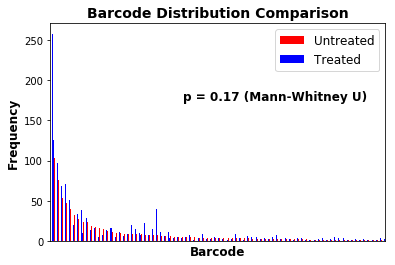

In [5]:
test = bcCountCompare.drop('Barcode_UT', axis = 1)
test.columns = ['Barcode', 'Untreated', 'Treated']
test1 = test.dropna()
test2 = test1.head()
# Must run previous chunk first bc of indexing here
test1.set_index('Barcode', inplace=True)
%matplotlib inline
fig = plt.figure(figsize=(8, 16))
test1.plot(kind='bar', color=['r','b']) # this is for all barcodes - hard to visualize
# test2.plot.bar()
plt.ylabel('Frequency', weight = "bold", size = 12)
plt.xlabel('Barcode', weight = "bold", size = 12)
plt.title('Barcode Distribution Comparison', weight = "bold", size = 14)
plt.legend(prop={'size': 12})
plt.text(x=100, y=175, s="p = 0.17 (Mann-Whitney U)", weight = "bold", size = 12)
frame1 = plt.gca()
frame1.axes.get_xaxis().set_ticks([])
plt.savefig('bcCount_comparison.pdf', bbox_inches = 'tight')


<Figure size 576x1152 with 0 Axes>

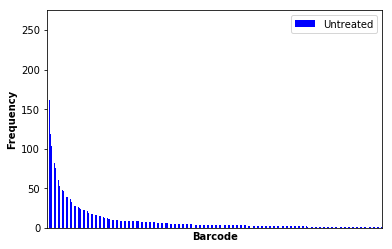

In [6]:
test3 = test1.drop(["Treated"], axis = 1)
fig = plt.figure(figsize=(8, 16))
test3.plot.bar(color = 'blue')
plt.ylabel('Frequency', weight = "bold")
plt.xlabel('Barcode', weight = "bold")
# # plt.legend(loc = 'upper left')
frame1 = plt.gca()
frame1.axes.get_xaxis().set_ticks([])
plt.ylim(0,275)
plt.savefig('bcCount_comparison_paperFigA.pdf', bbox_inches = 'tight')

<Figure size 576x1152 with 0 Axes>

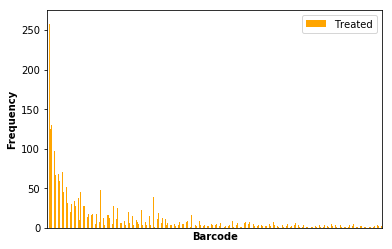

In [7]:
test4 = test1.drop(["Untreated"], axis = 1)
fig = plt.figure(figsize=(8, 16))
test4.plot.bar(color = 'orange')
plt.ylabel('Frequency', weight = "bold")
plt.xlabel('Barcode', weight = "bold")
# # plt.legend(loc = 'upper left')
frame1 = plt.gca()
frame1.axes.get_xaxis().set_ticks([])
plt.ylim(0,275)
plt.savefig('bcCount_comparison_paperFigB.pdf', bbox_inches = 'tight')

In [8]:
test1.head()

Untreated  Treated
Barcode                                 
CTGAGTCAGAGTGACACACT      176.0    176.0
CTGAGAGTGAGTCTGTCAGT      161.0    258.0
CTGAGTCACTCACTGAGTGT      118.0    125.0
CTGAGTGTGAGAGTGTGTGT      103.0    130.0
CTGACAGTGTCACACAGTGA       95.0    109.0

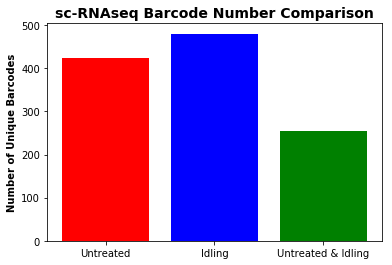

In [24]:
tot_UU = UU_bcCounts.shape[0]
tot_UT = UT_bcCounts.shape[0]
dat_idling_fromUntreated = test1.shape[0]

dt = ('Untreated', 'Idling', 'Untreated & Idling')
dat_x = np.arange(len(dt))
dat_y = [tot_UU, tot_UT, dat_idling_fromUntreated]

plt.bar(dat_x, dat_y, align='center', color=['r','b','g'])
plt.xticks(dat_x, dt)
plt.ylabel('Number of Unique Barcodes', weight = "bold")
plt.title('sc-RNAseq Barcode Number Comparison', weight = "bold", size = 14)
plt.savefig('barcodeNum_comparision.pdf', bbox_inches = 'tight')

In [10]:
test1['Untreated_Prop'] = test1['Untreated'] /  test1['Untreated'].sum()
test1['Treated_Prop'] = test1['Treated'] /  test1['Treated'].sum()

prop_df = test1[['Untreated_Prop', 'Treated_Prop']]
# prop_df['Prop_Diff'] = prop_df['Treated_Prop'] - prop_df['Untreated_Prop']
prop_df['Perc_Change_UtoT'] = abs((prop_df['Treated_Prop'] - prop_df['Untreated_Prop']) / prop_df['Untreated_Prop']) * 100.0
prop_df['Perc_Change_TtoU'] = abs((prop_df['Untreated_Prop'] - prop_df['Treated_Prop']) / prop_df['Treated_Prop']) * 100.0


prop_df

/Users/Corey/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/Corey/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Corey/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

Untreated_Prop  Treated_Prop  Perc_Change_UtoT  \
Barcode                                                                
CTGAGTCAGAGTGACACACT        0.066641      0.055363         16.923561   
CTGAGAGTGAGTCTGTCAGT        0.060962      0.081158         33.128704   
CTGAGTCACTCACTGAGTGT        0.044680      0.039321         11.995298   
CTGAGTGTGAGAGTGTGTGT        0.039000      0.040893          4.853758   
CTGACAGTGTCACACAGTGA        0.035971      0.034288          4.680717   
CTGAGAGACTCTGTGACTGA        0.031049      0.030513          1.726651   
CTGAGACTCAGACAGACACT        0.028777      0.021076         26.761560   
CTGACTGTCAGACAGAGTGA        0.024233      0.011324         53.269503   
CTGAGTCAGTCACACTCTGT        0.023097      0.021390          7.390199   
CTGACTGTCTGTCAGTGTGT        0.020068      0.018559          7.518681   
CTGACAGTGTGTCAGTCTCT        0.019690      0.019188          2.544946   
CTGAGAGTCACTGAGTGTGT        0.018175      0.022334         22.883900   
CTGAGTGTCACTCTCTCAGA        0.017796      0.014155         20.458728   
CTGACAGACACTCTCAGTCT        0.016282      0.043724        168.549420   
CTGAGTGTGACTGTGTGTGA        0.014767      0.016043          8.638420   
CTGACAGTCACACTGACTCA        0.014767      0.009751         33.964882   
CTGACTGTGTGTCAGTGTGA        0.014010      0.018874         34.718550   
CTGACTGAGAGTGAGTCACA        0.013631      0.006291         53.846423   
CTGAGAGTGACAGACTCAGT        0.012117      0.009437         22.115838   
CTGACACACTCTCACTGACA        0.010602      0.006291         40.659686   
CTGACTCTGTCACAGAGTGA        0.010602      0.010695          0.878533   
CTGACTCAGTCTGTCTGTCA        0.010223      0.008808         13.846656   
CTGAGTGTGAGTCTGTGACA        0.010223      0.007235         29.231181   
CTGACTGACTGTGTCTGTGA        0.009845      0.011953         21.419411   
CTGACAGTCAGTCAGTGTGA        0.009466      0.003146         66.769424   
CTGACTGAGAGACTGAGACA        0.009087      0.014155         55.768323   
CTGACACACTGTGACTGTGT        0.009087      0.011010         21.153140   
CTGAGTGTCACACACACTGA        0.008709      0.008808          1.136535   
CTGACTGTCTGAGAGTCACA        0.008709      0.008493          2.475484   
CTGAGAGACTGTCAGAGTCA        0.008330      0.003146         62.237982   
...                              ...           ...               ...   
CTGACTGTGTGTGACAGACA        0.000379      0.000315         16.923561   
CTGAGAGTGAGTGACAGTGT        0.000379      0.000315         16.923561   
CTGAGTGTGTGAGTGACTGT        0.000379      0.000315         16.923561   
CTGACAGTGAGAGAGAGAGT        0.000379      0.000629         66.152878   
CAGAGTCACTCACTGAGTGT        0.000379      0.000315         16.923561   
CTGACTGTCAGTCTCTGTCT        0.000379      0.001258        232.305757   
CTGACTCTCACTGAGACTGT        0.000379      0.000315         16.923561   
CTGACACTCTGAGTCAGA          0.000379      0.000629         66.152878   
CTGACACTGAGTCTCAGTGT        0.000379      0.001573        315.382196   
CTGAGAGTGACTGTCTGACA        0.000379      0.000944        149.229317   
CTGACAGAGAGTGTGTGTGT        0.000379      0.000315         16.923561   
CTGAGTCTCACTGAGTCACA        0.000379      0.000315         16.923561   
CTGAGTGACTGAGTCACACT        0.000379      0.001887        398.458635   
CTGAGTGAGACACACTGTGT        0.000379      0.000629         66.152878   
CTGACTCACAGTGTCAGACA        0.000379      0.000629         66.152878   
CTGACTGTGAGACTGTGTGA        0.000379      0.000315         16.923561   
CTGACTCACAGACTGTCAGA        0.000379      0.000315         16.923561   
CTGAGAGTCTGTGTGTCTGA        0.000379      0.000315         16.923561   
CTGAGACTGTGACAGACTCA        0.000379      0.001887        398.458635   
CTGACACTCTCTCTGAGTGA        0.000379      0.000629         66.152878   
CTGACAGAGTGAGACACTGT        0.000379      0.000315         16.923561   
CTGAGACTGTGAGTGAGACT        0.000379      0.000315         16.923561   
CTGACAGTGTGTCAGTCCCT        0.000379      0.000315         16.

In [26]:
# proportions
propOnly_df = prop_df
# propOnly_df['Untreated_Pct'] = propOnly_df['Untreated'] / propOnly_df['Untreated'].sum()
# propOnly_df['Treated_Pct'] = propOnly_df['Treated'] / propOnly_df['Treated'].sum()
propOnly_df = propOnly_df.drop(['Perc_Change_UtoT', 'Perc_Change_TtoU'], axis = 1)
propOnly_df.head()

Untreated_Prop  Treated_Prop
Barcode                                           
CTGAGTCAGAGTGACACACT        0.066641      0.055363
CTGAGAGTGAGTCTGTCAGT        0.060962      0.081158
CTGAGTCACTCACTGAGTGT        0.044680      0.039321
CTGAGTGTGAGAGTGTGTGT        0.039000      0.040893
CTGACAGTGTCACACAGTGA        0.035971      0.034288

In [31]:
relAbund_df = propOnly_df
relAbund_df.rename(columns={'Untreated_Prop': 'Untreated', 'Treated_Prop': 'Idling'}, inplace=True)
relAbund_df.head()

Untreated    Idling
Barcode                                  
CTGAGTCAGAGTGACACACT   0.066641  0.055363
CTGAGAGTGAGTCTGTCAGT   0.060962  0.081158
CTGAGTCACTCACTGAGTGT   0.044680  0.039321
CTGAGTGTGAGAGTGTGTGT   0.039000  0.040893
CTGACAGTGTCACACAGTGA   0.035971  0.034288

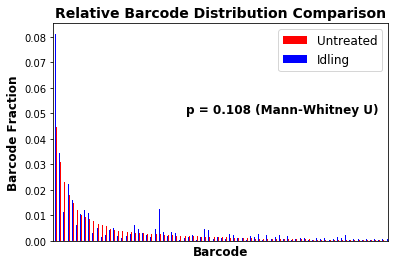

In [37]:
from scipy.stats import mannwhitneyu

# fig = plt.figure(figsize=(8, 16))
relAbund_df.plot(kind='bar', color=['r','b']) # this is for all barcodes - hard to visualize
plt.ylabel('Barcode Fraction', weight = "bold", size = 12)
plt.xlabel('Barcode', weight = "bold", size = 12)
plt.title('Relative Barcode Distribution Comparison', weight = "bold", size = 14)
plt.legend(prop={'size': 12})
stat, p = mannwhitneyu(relAbund_df['Untreated'], relAbund_df['Idling'])
plt.text(x=100, y=0.05, s="p = %.3f (Mann-Whitney U)" % (p), weight = "bold", size = 12)
frame1 = plt.gca()
frame1.axes.get_xaxis().set_ticks([])
plt.savefig('relbcCount_comparison.pdf', bbox_inches = 'tight')


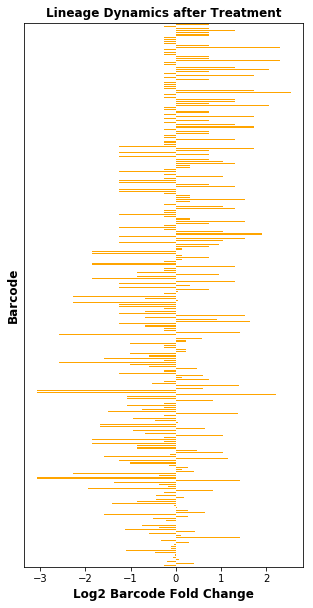

In [23]:
propOnly_df['Fold_Change'] = propOnly_df['Treated_Prop'] / propOnly_df['Untreated_Prop']

propOnly_df['Log2_Fold_Change'] = np.log2(propOnly_df['Fold_Change']) 

propOnly_df.plot.barh(y='Log2_Fold_Change', legend = False, color = 'orange', figsize=(5,10))
frame2 = plt.gca()
frame2.axes.get_yaxis().set_ticks([])
plt.xlabel('Log2 Barcode Fold Change', weight = "bold", size=12)
plt.ylabel('Barcode', weight = "bold", size=12)
plt.title('Lineage Dynamics after Treatment', weight = "bold", size=12)
plt.savefig('bcFoldChange_norm.pdf')

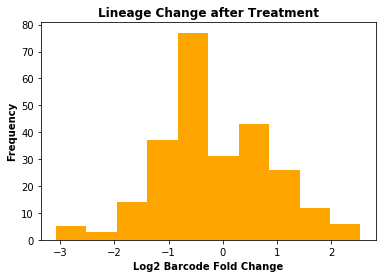

In [18]:
propOnly_df['Log2_Fold_Change'].plot.hist(color='orange')
plt.xlabel('Log2 Barcode Fold Change', weight = "bold")
plt.ylabel('Frequency', weight = "bold")
plt.title('Lineage Change after Treatment', weight = "bold", size=12)
plt.savefig('bcFoldChange_hist.pdf', bbox_inches = 'tight')

propOnly_Untreated = propOnly_df.drop(["Treated_Prop"], axis = 1)
fig = plt.figure(figsize=(10, 25))
propOnly_Untreated.plot.bar(color = 'red', legend = False)
plt.ylim(0,0.085)
plt.ylabel('Barcode Fraction', weight = "bold", size = 12)
plt.xlabel('Barcode', weight = "bold", size = 12)
plt.title('Untreated', weight="bold", size = 14)
frame1 = plt.gca()
frame1.axes.get_xaxis().set_ticks([])
plt.savefig('bcCount_comparison_prop_paperFigA.pdf', bbox_inches = 'tight')

<Figure size 720x1800 with 0 Axes>

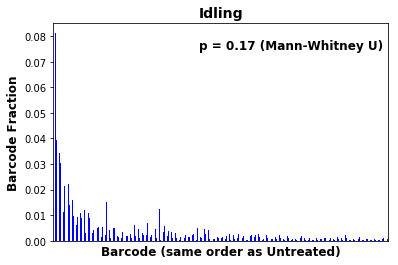

In [47]:
propOnly_Untreated = propOnly_df.drop(["Untreated_Prop"], axis = 1)
fig = plt.figure(figsize=(10, 25))
propOnly_Untreated.plot.bar(color = 'blue', legend = False)
plt.ylim(0,0.085)
plt.ylabel('Barcode Fraction', weight = "bold", size = 12)
plt.xlabel('Barcode (same order as Untreated)', weight = "bold", size = 12)
plt.title('Idling', weight="bold", size = 14)
plt.text(x=110, y=0.075, s="p = 0.17 (Mann-Whitney U)", weight = "bold", size = 12)
# # plt.legend(loc = 'upper left')
frame1 = plt.gca()
frame1.axes.get_xaxis().set_ticks([])
plt.savefig('bcCount_comparison_prop_paperFigB.pdf', bbox_inches = 'tight')

In [7]:
import scipy.stats as stats
stats.f_oneway(propOnly_df['Untreated_Prop'], propOnly_df['Treated_Prop'])

F_onewayResult(statistic=-7.7639730328614592e-31, pvalue=nan)

In [10]:
propOnly_df['Untreated_Prop'].to_csv("untreated_prop_series.csv")
propOnly_df['Treated_Prop'].to_csv("treated_prop_series.csv")

In [ ]:
# import rpy2
# %load_ext rpy2.ipython

# untreated_bc_list = list(prop_df['Untreated_Prop'])
# treated_bc_list = list(prop_df['Treated_Prop'])

# %Rpush untreated_bc_list treated_bc_list

# #label the conditions
# %R Factor <- c('Untreated','Treated')
# #create a vector of conditions
# %R idata <- data.frame(Factor)

# #combine data into single matrix
# %R Bind <- cbind(untreated_bc_list, treated_bc_list)
# #generate linear model
# %R model <- lm(Bind~1)

# #load the car library. note this library must be installed.
# %R install.packages("car")
# %R library(car)
# #run anova
# %R analysis <- Anova(model,idata=idata,idesign=~Factor,type="III")
# #create anova summary table
# %R anova_sum = summary(analysis)

# #move the data from R to python
# %Rpull anova_sum
# print anova_sum

In [16]:
# plot difference of proportions as histogram
test3 = propOnly_df
# test3.set_index('Barcode', inplace=True)
test3.plot.hist(alpha = 0.5, bins = 200)
# plt.savefig('UU_UT_barcodeDist.pdf')

In [ ]:
# statistical test - can we do that with only one measurement? (ANOVA)

In [19]:
UU_barcodes = UU_bcCounts['Barcode_UU']
UU_barcodes_list = UU_barcodes.tolist()
UU_barcodes_list

UT_barcodes = UT_bcCounts['Barcode_UT']
UT_barcodes_list = UT_barcodes.tolist()
UT_barcodes_list

['CTGAGAGTGAGTCTGTCAGT',
 'CTGAGTCAGAGTGACACACT',
 'CTGACAGACACTCTCAGTCT',
 'CTGAGTGTGAGAGTGTGTGT',
 'CTGAGTCACTCACTGAGTGT',
 'CTGACAGTGTCACACAGTGA',
 'CTGAGAGACTCTGTGACTGA',
 'CTGAGAGTCACTGAGTGTGT',
 'CTGAGTCAGTCACACTCTGT',
 'CTGAGACTCAGACAGACACT',
 'CTGACAGTGTGTCAGTCTCT',
 'CTGACTGTGTGTCAGTGTGA',
 'CTGACTGTCTGTCAGTGTGT',
 'CTGAGTGTGACTGTGTGTGA',
 'CTGAGAGTCAGTGAGTCTCT',
 'CTGACTGAGAGACTGAGACA',
 'CTGAGTGTCACTCTCTCAGA',
 'CTGACTGAGAGTGACACTGA',
 'CTGACTGACTGTGTCTGTGA',
 'CTGACAGTGTGTGACTGACT',
 'CTGACTGTCAGACAGAGTGA',
 'CTGACACACTGTGACTGTGT',
 'CTGACTCTGTCACAGAGTGA',
 'CTGACAGTCACACTGACTCA',
 'CTGAGAGTGACAGACTCAGT',
 'CTGAGTGTCACACACACTGA',
 'CTGACTCAGTCTGTCTGTCA',
 'CTGAGAGACAGAGAGAGTCA',
 'CTGACTGTCTGAGAGTCACA',
 'CTGACTCTCTCTCAGACTGA',
 'CTGAGTGACAGTCACAGACT',
 'CTGAGTGTGAGTCTGTGACA',
 'CTGAGAGTCTCAGACTGAGT',
 'CTGACACACTCTCACTGACA',
 'CTGACTGAGAGTGAGTCACA',
 'CTGAGTGAGTGAGTCACAGA',
 'CTGAGACACACAGTGTGTGT',
 'CTGACACTGTCTCTCTGACA',
 'CTGAGTGACTGTGAGACTGA',
 'CTGAGTGTGTGAGTCACAGT',


In [20]:
# Computing distance metric between unique barcodes
import Levenshtein
comparisons_UU = []
Lev_dists_UU = []
lineage_bc1s_UU = []
lineage_bc2s_UU = []

for i in range(len(UU_barcodes_list)):
    for j in range(i+1, len(UU_barcodes_list)):
        comp = UU_barcodes_list[i] + "_" + UU_barcodes_list[j]
        comparisons_UU.append(comp)
        lineage_bc1_UU = UU_barcodes_list[i]
        lineage_bc1s_UU.append(lineage_bc1)
        lineage_bc2_UU = UU_barcodes_list[j]
        lineage_bc2s_UU.append(lineage_bc2)
        ld=Levenshtein.distance(UU_barcodes_list[i], UU_barcodes_list[j])
        Lev_dists_UU.append(ld)
        

comparisons_UT = []
Lev_dists_UT = []
lineage_bc1s_UT = []
lineage_bc2s_UT = []

for i in range(len(UT_barcodes_list)):
    for j in range(i+1, len(UT_barcodes_list)):
        comp = UT_barcodes_list[i] + "_" + UT_barcodes_list[j]
        comparisons_UT.append(comp)
        lineage_bc1_UT = UT_barcodes_list[i]
        lineage_bc1s_UT.append(lineage_bc1)
        lineage_bc2_UT = UT_barcodes_list[j]
        lineage_bc2s_UT.append(lineage_bc2)
        ld=Levenshtein.distance(UT_barcodes_list[i], UT_barcodes_list[j])
        Lev_dists_UT.append(ld)

In [22]:
distance_comparisons_UU = pd.DataFrame(
                        {'Lineage Barcode Comparison': comparisons_UU,
                         'Levenshtein Distance': Lev_dists_UU,
                         'Lineage Barcode 1': lineage_bc1s_UU,
                         'Lineage Barcode 2': lineage_bc2s_UU})

distance_comparisons_UT = pd.DataFrame(
                        {'Lineage Barcode Comparison': comparisons_UT,
                         'Levenshtein Distance': Lev_dists_UT,
                         'Lineage Barcode 1': lineage_bc1s_UT,
                         'Lineage Barcode 2': lineage_bc2s_UT})

distance_comparisons_UT.head()

Levenshtein Distance     Lineage Barcode 1     Lineage Barcode 2  \
0                     8  CTGAGTGTCTCACTCTGAGA  CTGACTGAGACTGAGAGAGA   
1                     8  CTGAGTGTCTCACTCTGAGA  CTGACTGAGACTGAGAGAGA   
2                     5  CTGAGTGTCTCACTCTGAGA  CTGACTGAGACTGAGAGAGA   
3                     9  CTGAGTGTCTCACTCTGAGA  CTGACTGAGACTGAGAGAGA   
4                     8  CTGAGTGTCTCACTCTGAGA  CTGACTGAGACTGAGAGAGA   

                  Lineage Barcode Comparison  
0  CTGAGAGTGAGTCTGTCAGT_CTGAGTCAGAGTGACACACT  
1  CTGAGAGTGAGTCTGTCAGT_CTGACAGACACTCTCAGTCT  
2  CTGAGAGTGAGTCTGTCAGT_CTGAGTGTGAGAGTGTGTGT  
3  CTGAGAGTGAGTCTGTCAGT_CTGAGTCACTCACTGAGTGT  
4  CTGAGAGTGAGTCTGTCAGT_CTGACAGTGTCACACAGTGA

In [24]:
distance_comparisons_sorted_UU = distance_comparisons_UU.sort_values('Levenshtein Distance')
distance_comparisons_sorted_UT = distance_comparisons_UT.sort_values('Levenshtein Distance')

distance_comparisons_sorted_UT.head()

Levenshtein Distance     Lineage Barcode 1     Lineage Barcode 2  \
9642                      1  CTGAGTGTCTCACTCTGAGA  CTGACTGAGACTGAGAGAGA   
18939                     1  CTGAGTGTCTCACTCTGAGA  CTGACTGAGACTGAGAGAGA   
58009                     1  CTGAGTGTCTCACTCTGAGA  CTGACTGAGACTGAGAGAGA   
10586                     1  CTGAGTGTCTCACTCTGAGA  CTGACTGAGACTGAGAGAGA   
2244                      1  CTGAGTGTCTCACTCTGAGA  CTGACTGAGACTGAGAGAGA   

                      Lineage Barcode Comparison  
9642   CTGACTGTCAGACAGAGTGA_CTGACTGTCAGACAGAGTCA  
18939  CTGAGAGTGAGTGTCTGACA_CTGAGAGTGACTGTCTGACA  
58009  CTGAGACTGACTCACACTGA_CTGAGACTGTCTCACACTGA  
10586  CTGACTCTGTCACAGAGTGA_CTGACTCTTTCACAGAGTGA  
2244   CTGAGTCACTCACTGAGTGT_CTGAGTCACTCAATGAGTGT

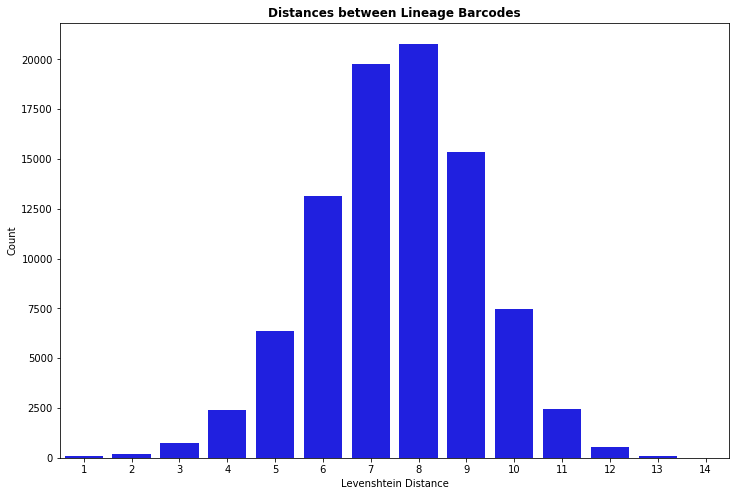

In [25]:
import seaborn as sns
%matplotlib inline
dims = (12,8)

fig,ax = plt.subplots(figsize=dims)
sns.countplot(x = "Levenshtein Distance",
              data = distance_comparisons_sorted_UU, 
              color = 'blue')
plt.ylabel("Count")
plt.title("Distances between Lineage Barcodes", weight = "bold")
plt.savefig("UU_LDall_distribution.pdf")

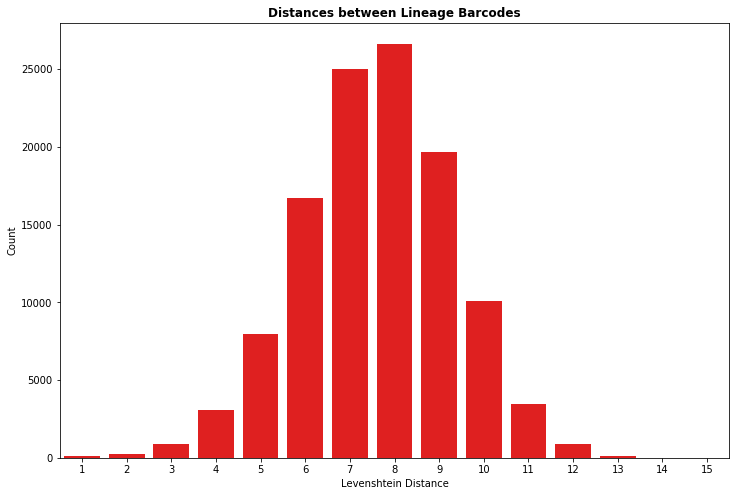

In [26]:
fig,ax = plt.subplots(figsize=dims)
sns.countplot(x = "Levenshtein Distance",
              data = distance_comparisons_sorted_UT, 
              color = 'red')
plt.ylabel("Count")
plt.title("Distances between Lineage Barcodes", weight = "bold")
plt.savefig("UT_LDall_distribution.pdf")